# Generative Modelling

<p style="font-size:20px">Generative models, or deep generative models, are a class of deep learning models that learn the underlying data distribution from the sample. These models can be used to reduce data into its fundamental properties, or to generate new samples of data with new and varied properties</p>

# Generative Adversarial Networks

<p style="font-size:20px">Generative adversarial networks are implicit likelihood models that generate data samples from the statistical distribution of the data. They’re used to copy variations within the dataset. They use a combination of two networks: generator and discriminator.</p>
<br>
<img src="https://miro.medium.com/v2/resize:fit:720/1*9jwIuW0KPi3THIvoYg9BUQ.png" />



## <u> The Generator: </u>
<p style="font-size:20px">A generator network takes a random normal distribution (z), and outputs a generated sample that’s close to the original distribution.</p>

## <u> The Discriminator: </u>
<p style="font-size:20px">A discriminator tries to evaluate the output generated by the generator with the original sample, and outputs a value between 0 and 1. If the value is close to 0, then the generated sample is fake, and if the value is close to 1 then the generated sample is real.</p>

## <u> What the Entire thing looks like: </u>

<br><img src="https://s3.amazonaws.com/kajabi-storefronts-production/blogs/12746/images/iAOOdduQyCICwiv31aHa_dcgan.png">

## <u> How do GANs work ? </u>

<p style="font-size:20px">A random normal distribution is fed into the generator. The generator then outputs a random distribution, since it doesn’t have a reference point. <br>
Meanwhile, an actual sample, or ground truth, is fed into the discriminator. The discriminator learns the distribution of the actual sample. When the generated sample from the generator is fed into the discriminator, it evaluates the distribution.<br>
If the distribution of the generated sample is close to the original sample, then the discriminator outputs a value close to ‘1’ = real. If both the distribution doesn’t match or they aren’t even close to each other, then the discriminator outputs a value close to ‘0’ = fake.</p>

## <u> The Minimax setting </u>

<br><img src="https://static.packt-cdn.com/products/9781789139907/graphics/bf03e5ab-69ac-424d-84a7-48ea85e616ec.png" style="width:900px; height:150px;">

<p style="font-size:20px">The answer lies in the loss function or the value function; it measures the distance between the distribution of the data generated and the distribution of the real data. Both the generator and the discriminator have their own loss functions. The generator tries to minimize the loss function while the discriminator tries to maximize.</p>

# Setup

**In this project, I have used**
* Numpy and Tensorflow for Mathematical Operations
* Matplotlib and OpenCV for Image data handling and Visualization
* Keras for the Neural Networks

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers.legacy import Adam
except:
    from keras.optimizers import Adam

In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
MAIN_DIR = "/Users/elizabethnemeti/Desktop/pngs"

# Loading and Preprocessing the Images

In [4]:
def load_images(folder):
    imgs = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder, i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))
            imgs.append(img)
        except Exception as e:
            print(f"Failed to process image {img_dir}: {e}")
            continue
    
    imgs = np.array(imgs)
    return imgs

In [5]:
data = load_images(MAIN_DIR)
data.shape

(2034, 128, 128)

## Generate 20 random numbers to index images from data

In [6]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [7]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

## Normalize and Reshape the Data

In [8]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

## Plotting The Real Images

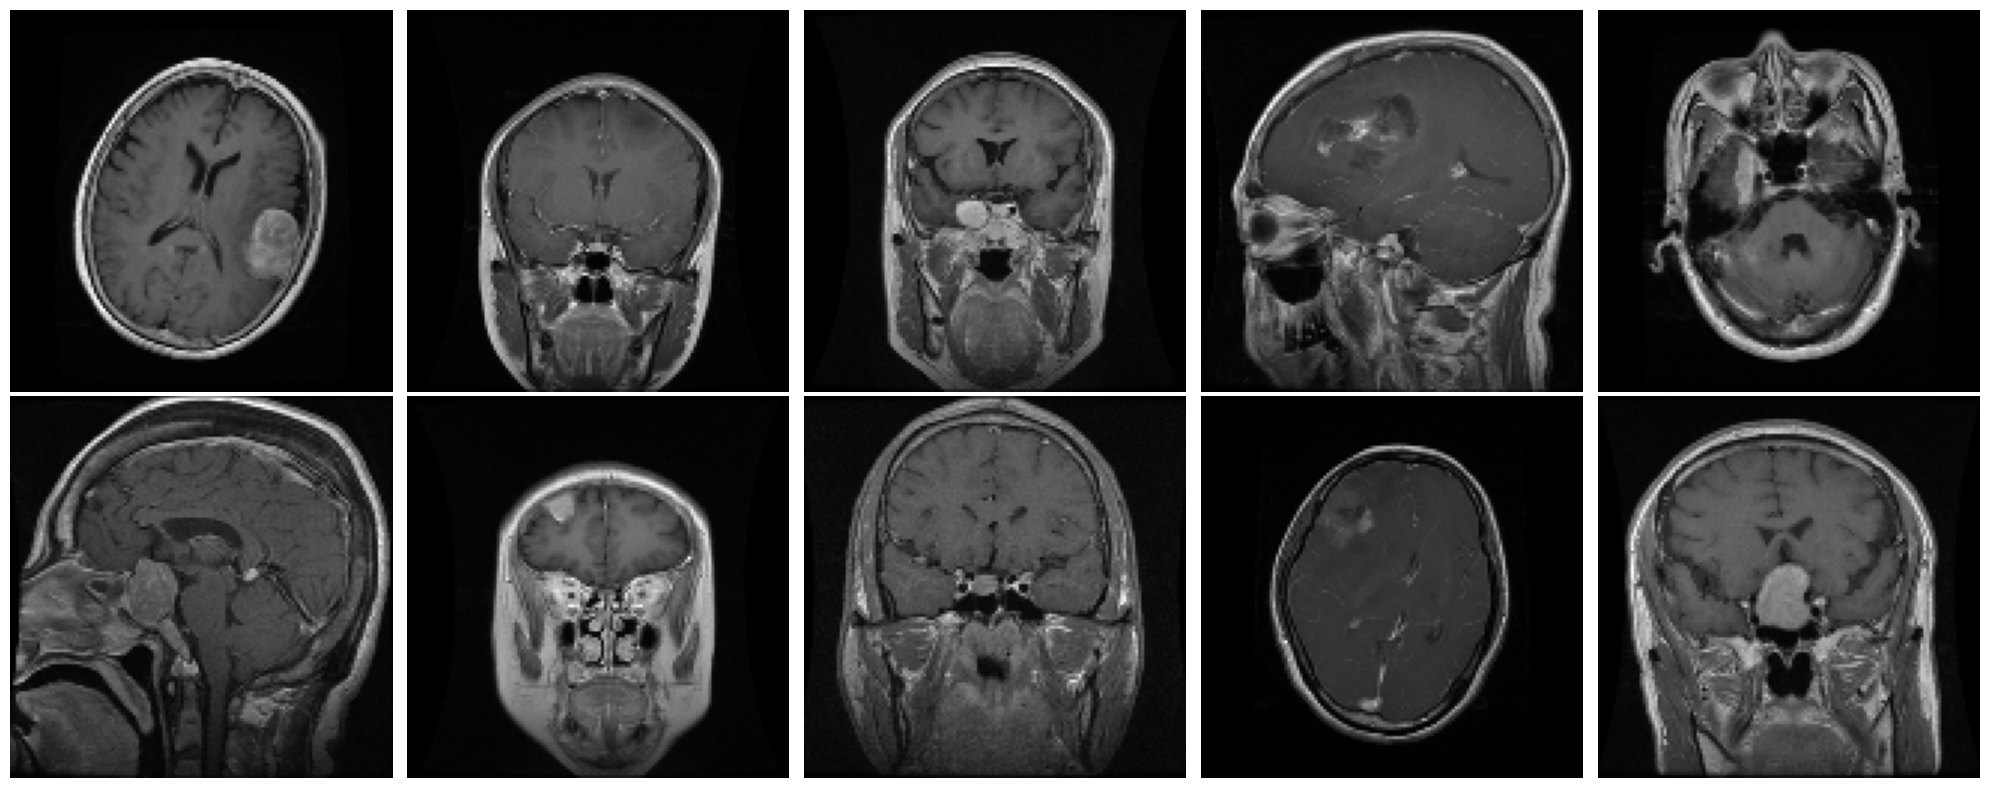

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# The Architecture

In [10]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [11]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

# Putting it together

In [12]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)   

In [13]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## The Training

In [ ]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

  0%|                                                  | 0/3750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 124ms/step


  0%|                                          | 1/3750 [00:00<56:18,  1.11it/s]

1/1 [==============================] - 0s 9ms/step


  0%|                                          | 2/3750 [00:01<27:06,  2.30it/s]

1/1 [==============================] - 0s 8ms/step


  0%|                                          | 3/3750 [00:01<18:58,  3.29it/s]

1/1 [==============================] - 0s 10ms/step


  0%|                                          | 4/3750 [00:01<14:16,  4.37it/s]

1/1 [==============================] - 0s 9ms/step


  0%|                                          | 5/3750 [00:01<11:33,  5.40it/s]

1/1 [==============================] - 0s 8ms/step


  0%|                                          | 6/3750 [00:01<09:49,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


  0%|                                          | 7/3750 [00:01<09:06,  6.84it/s]

1/1 [==============================] - 0s 10ms/step


  0%|                                          | 8/3750 [00:01<08:34,  7.28it/s]

1/1 [==============================] - 0s 8ms/step


  0%|                                          | 9/3750 [00:01<08:02,  7.75it/s]

1/1 [==============================] - 0s 8ms/step


  0%|                                         | 10/3750 [00:01<07:39,  8.14it/s]

1/1 [==============================] - 0s 8ms/step


  0%|                                         | 11/3750 [00:02<07:18,  8.52it/s]

1/1 [==============================] - 0s 8ms/step


  0%|▏                                        | 12/3750 [00:02<07:08,  8.72it/s]

1/1 [==============================] - 0s 8ms/step


  0%|▏                                        | 13/3750 [00:02<07:00,  8.88it/s]

1/1 [==============================] - 0s 8ms/step


  0%|▏                                        | 14/3750 [00:02<06:49,  9.12it/s]

1/1 [==============================] - 0s 8ms/step


  0%|▏                                        | 15/3750 [00:02<06:46,  9.20it/s]

1/1 [==============================] - 0s 9ms/step


  0%|▏                                        | 16/3750 [00:02<06:49,  9.13it/s]

1/1 [==============================] - 0s 8ms/step


  0%|▏                                        | 17/3750 [00:02<06:42,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


  0%|▏                                        | 18/3750 [00:02<06:35,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▏                                        | 19/3750 [00:02<06:31,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▏                                        | 20/3750 [00:02<06:29,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▏                                        | 21/3750 [00:03<06:30,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▏                                        | 22/3750 [00:03<06:28,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▎                                        | 23/3750 [00:03<06:27,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▎                                        | 24/3750 [00:03<06:25,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▎                                        | 25/3750 [00:03<06:24,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▎                                        | 26/3750 [00:03<06:23,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▎                                        | 27/3750 [00:03<06:23,  9.72it/s]

1/1 [==============================] - 0s 7ms/step


  1%|▎                                        | 28/3750 [00:03<06:26,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▎                                        | 29/3750 [00:03<06:31,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▎                                        | 30/3750 [00:04<06:31,  9.50it/s]

1/1 [==============================] - 0s 11ms/step


  1%|▎                                        | 31/3750 [00:04<06:49,  9.08it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▎                                        | 32/3750 [00:04<07:01,  8.82it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▎                                        | 33/3750 [00:04<07:09,  8.65it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▎                                        | 34/3750 [00:04<07:00,  8.85it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▍                                        | 35/3750 [00:04<06:49,  9.06it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▍                                        | 36/3750 [00:04<06:44,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▍                                        | 37/3750 [00:04<06:44,  9.17it/s]

1/1 [==============================] - 0s 10ms/step


  1%|▍                                        | 38/3750 [00:04<06:51,  9.01it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▍                                        | 39/3750 [00:05<06:53,  8.97it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▍                                        | 40/3750 [00:05<06:45,  9.15it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▍                                        | 41/3750 [00:05<06:41,  9.23it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▍                                        | 42/3750 [00:05<06:35,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▍                                        | 43/3750 [00:05<06:35,  9.37it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▍                                        | 44/3750 [00:05<06:44,  9.16it/s]

1/1 [==============================] - 0s 10ms/step


  1%|▍                                        | 45/3750 [00:05<06:50,  9.02it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▌                                        | 46/3750 [00:05<07:00,  8.81it/s]

1/1 [==============================] - 0s 11ms/step


  1%|▌                                        | 47/3750 [00:05<07:09,  8.63it/s]

1/1 [==============================] - 0s 11ms/step


  1%|▌                                        | 48/3750 [00:06<07:20,  8.40it/s]

1/1 [==============================] - 0s 10ms/step


  1%|▌                                        | 49/3750 [00:06<07:25,  8.30it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▌                                        | 50/3750 [00:06<07:25,  8.31it/s]

1/1 [==============================] - 0s 10ms/step


  1%|▌                                        | 51/3750 [00:06<07:24,  8.32it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▌                                        | 52/3750 [00:06<07:19,  8.41it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▌                                        | 53/3750 [00:06<07:15,  8.48it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▌                                        | 54/3750 [00:06<07:16,  8.46it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▌                                        | 55/3750 [00:06<07:13,  8.53it/s]

1/1 [==============================] - 0s 9ms/step


  1%|▌                                        | 56/3750 [00:07<07:15,  8.49it/s]

1/1 [==============================] - 0s 10ms/step


  2%|▌                                        | 57/3750 [00:07<07:16,  8.46it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 58/3750 [00:07<07:13,  8.52it/s]

1/1 [==============================] - 0s 10ms/step


  2%|▋                                        | 59/3750 [00:07<07:14,  8.49it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 60/3750 [00:07<07:13,  8.52it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 61/3750 [00:07<07:13,  8.51it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 62/3750 [00:07<07:10,  8.56it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 63/3750 [00:07<07:09,  8.58it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 64/3750 [00:07<07:09,  8.58it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▋                                        | 65/3750 [00:08<07:10,  8.56it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 66/3750 [00:08<07:06,  8.63it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▋                                        | 67/3750 [00:08<07:02,  8.72it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▋                                        | 68/3750 [00:08<07:01,  8.74it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 69/3750 [00:08<07:03,  8.68it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 70/3750 [00:08<07:00,  8.75it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 71/3750 [00:08<07:00,  8.74it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▊                                        | 72/3750 [00:08<06:56,  8.83it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▊                                        | 73/3750 [00:08<06:49,  8.99it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 74/3750 [00:09<06:41,  9.16it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 75/3750 [00:09<06:35,  9.30it/s]

1/1 [==============================] - 0s 7ms/step


  2%|▊                                        | 76/3750 [00:09<06:29,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 77/3750 [00:09<06:25,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 78/3750 [00:09<06:21,  9.62it/s]

1/1 [==============================] - 0s 7ms/step


  2%|▊                                        | 79/3750 [00:09<06:20,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▊                                        | 80/3750 [00:09<06:18,  9.70it/s]

1/1 [==============================] - 0s 7ms/step


  2%|▉                                        | 81/3750 [00:09<06:21,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▉                                        | 82/3750 [00:09<06:36,  9.25it/s]

1/1 [==============================] - 0s 10ms/step


  2%|▉                                        | 83/3750 [00:10<06:38,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▉                                        | 84/3750 [00:10<06:32,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▉                                        | 85/3750 [00:10<06:28,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▉                                        | 86/3750 [00:10<06:29,  9.41it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▉                                        | 87/3750 [00:10<06:38,  9.19it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▉                                        | 88/3750 [00:10<06:33,  9.30it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▉                                        | 89/3750 [00:10<06:28,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


  2%|▉                                        | 90/3750 [00:10<06:30,  9.37it/s]

1/1 [==============================] - 0s 9ms/step


  2%|▉                                        | 91/3750 [00:10<06:30,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


  2%|█                                        | 92/3750 [00:10<06:29,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


  2%|█                                        | 93/3750 [00:11<06:24,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                        | 94/3750 [00:11<06:25,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                        | 95/3750 [00:11<06:24,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                        | 96/3750 [00:11<06:21,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                        | 97/3750 [00:11<06:19,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                        | 98/3750 [00:11<06:17,  9.68it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                        | 99/3750 [00:11<06:15,  9.72it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                       | 100/3750 [00:11<06:14,  9.74it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█                                       | 101/3750 [00:11<06:19,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                       | 102/3750 [00:12<06:18,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█                                       | 103/3750 [00:12<06:22,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█                                       | 104/3750 [00:12<06:31,  9.32it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█                                       | 105/3750 [00:12<06:30,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▏                                      | 106/3750 [00:12<06:26,  9.42it/s]

1/1 [==============================] - 0s 18ms/step


  3%|█▏                                      | 107/3750 [00:12<06:39,  9.12it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▏                                      | 108/3750 [00:12<06:38,  9.15it/s]

1/1 [==============================] - 0s 13ms/step


  3%|█▏                                      | 109/3750 [00:12<06:47,  8.94it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▏                                      | 110/3750 [00:12<06:48,  8.91it/s]

1/1 [==============================] - 0s 12ms/step


  3%|█▏                                      | 111/3750 [00:13<06:56,  8.74it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▏                                      | 112/3750 [00:13<06:56,  8.74it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▏                                      | 113/3750 [00:13<06:50,  8.85it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▏                                      | 114/3750 [00:13<06:57,  8.72it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▏                                      | 115/3750 [00:13<06:59,  8.67it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▏                                      | 116/3750 [00:13<07:08,  8.47it/s]

1/1 [==============================] - 0s 10ms/step


  3%|█▏                                      | 117/3750 [00:13<07:00,  8.64it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 118/3750 [00:13<06:46,  8.93it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 119/3750 [00:13<06:47,  8.91it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 120/3750 [00:14<06:36,  9.14it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 121/3750 [00:14<06:29,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 122/3750 [00:14<06:25,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 123/3750 [00:14<06:21,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 124/3750 [00:14<06:22,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 125/3750 [00:14<06:19,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▎                                      | 126/3750 [00:14<06:17,  9.61it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▎                                      | 127/3750 [00:14<06:37,  9.10it/s]

1/1 [==============================] - 0s 9ms/step


  3%|█▎                                      | 128/3750 [00:14<06:46,  8.92it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▍                                      | 129/3750 [00:15<06:36,  9.12it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▍                                      | 130/3750 [00:15<06:29,  9.30it/s]

1/1 [==============================] - 0s 8ms/step


  3%|█▍                                      | 131/3750 [00:15<06:25,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▍                                      | 132/3750 [00:15<06:21,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▍                                      | 133/3750 [00:15<06:18,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▍                                      | 134/3750 [00:15<06:16,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▍                                      | 135/3750 [00:15<06:14,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▍                                      | 136/3750 [00:15<06:22,  9.46it/s]

1/1 [==============================] - 0s 9ms/step


  4%|█▍                                      | 137/3750 [00:15<06:32,  9.20it/s]

1/1 [==============================] - 0s 9ms/step


  4%|█▍                                      | 138/3750 [00:15<06:32,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▍                                      | 139/3750 [00:16<06:26,  9.35it/s]

1/1 [==============================] - 0s 9ms/step


  4%|█▍                                      | 140/3750 [00:16<06:24,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 141/3750 [00:16<06:21,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 142/3750 [00:16<06:19,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 143/3750 [00:16<06:21,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 144/3750 [00:16<06:22,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 145/3750 [00:16<06:30,  9.24it/s]

1/1 [==============================] - 0s 9ms/step


  4%|█▌                                      | 146/3750 [00:16<06:39,  9.02it/s]

1/1 [==============================] - 0s 11ms/step


  4%|█▌                                      | 147/3750 [00:16<07:06,  8.45it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 148/3750 [00:17<06:51,  8.76it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 149/3750 [00:17<06:38,  9.03it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 150/3750 [00:17<06:32,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 151/3750 [00:17<06:28,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▌                                      | 152/3750 [00:17<06:28,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 153/3750 [00:17<06:32,  9.17it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 154/3750 [00:17<06:24,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 155/3750 [00:17<06:19,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 156/3750 [00:17<06:17,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 157/3750 [00:18<06:14,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 158/3750 [00:18<06:12,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 159/3750 [00:18<06:12,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 160/3750 [00:18<06:10,  9.68it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 161/3750 [00:18<06:09,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 162/3750 [00:18<06:08,  9.74it/s]

1/1 [==============================] - 0s 8ms/step


  4%|█▋                                      | 163/3750 [00:18<06:15,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


  4%|█▋                                      | 164/3750 [00:18<06:18,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


  4%|█▊                                      | 165/3750 [00:18<06:29,  9.20it/s]

1/1 [==============================] - 0s 9ms/step


  4%|█▊                                      | 166/3750 [00:18<06:36,  9.04it/s]

1/1 [==============================] - 0s 10ms/step


  4%|█▊                                      | 167/3750 [00:19<06:47,  8.79it/s]

1/1 [==============================] - 0s 11ms/step


  4%|█▊                                      | 168/3750 [00:19<06:46,  8.82it/s]

1/1 [==============================] - 0s 9ms/step


  5%|█▊                                      | 169/3750 [00:19<06:38,  8.99it/s]

1/1 [==============================] - 0s 9ms/step


  5%|█▊                                      | 170/3750 [00:19<06:35,  9.05it/s]

1/1 [==============================] - 0s 9ms/step


  5%|█▊                                      | 171/3750 [00:19<06:32,  9.12it/s]

1/1 [==============================] - 0s 10ms/step


  5%|█▊                                      | 172/3750 [00:19<06:41,  8.92it/s]

1/1 [==============================] - 0s 10ms/step


  5%|█▊                                      | 173/3750 [00:19<06:50,  8.71it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▊                                      | 174/3750 [00:19<06:45,  8.81it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▊                                      | 175/3750 [00:19<06:35,  9.04it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 176/3750 [00:20<06:27,  9.23it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 177/3750 [00:20<06:22,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 178/3750 [00:20<06:19,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 179/3750 [00:20<06:16,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 180/3750 [00:20<06:13,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 181/3750 [00:20<06:10,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


  5%|█▉                                      | 182/3750 [00:20<06:10,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 183/3750 [00:20<06:11,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 184/3750 [00:20<06:10,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 185/3750 [00:21<06:10,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 186/3750 [00:21<06:13,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


  5%|█▉                                      | 187/3750 [00:21<06:10,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 188/3750 [00:21<06:08,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 189/3750 [00:21<06:07,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 190/3750 [00:21<06:06,  9.72it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 191/3750 [00:21<06:05,  9.74it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 192/3750 [00:21<06:07,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 193/3750 [00:21<06:05,  9.73it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 194/3750 [00:21<06:05,  9.73it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 195/3750 [00:22<06:05,  9.73it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 196/3750 [00:22<06:04,  9.74it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 197/3750 [00:22<06:04,  9.73it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 198/3750 [00:22<06:04,  9.75it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██                                      | 199/3750 [00:22<06:32,  9.05it/s]

1/1 [==============================] - 0s 10ms/step


  5%|██▏                                     | 200/3750 [00:22<06:51,  8.63it/s]

1/1 [==============================] - 0s 9ms/step


  5%|██▏                                     | 201/3750 [00:22<06:41,  8.83it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██▏                                     | 202/3750 [00:22<06:31,  9.06it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██▏                                     | 203/3750 [00:22<06:23,  9.25it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██▏                                     | 204/3750 [00:23<06:18,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██▏                                     | 205/3750 [00:23<06:14,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


  5%|██▏                                     | 206/3750 [00:23<06:14,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▏                                     | 207/3750 [00:23<06:13,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▏                                     | 208/3750 [00:23<06:15,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▏                                     | 209/3750 [00:23<06:11,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▏                                     | 210/3750 [00:23<06:10,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 211/3750 [00:23<06:07,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 212/3750 [00:23<06:06,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 213/3750 [00:23<06:04,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 214/3750 [00:24<06:03,  9.73it/s]

1/1 [==============================] - 0s 7ms/step


  6%|██▎                                     | 215/3750 [00:24<06:02,  9.74it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 216/3750 [00:24<06:02,  9.75it/s]

1/1 [==============================] - 0s 7ms/step


  6%|██▎                                     | 217/3750 [00:24<06:01,  9.77it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 218/3750 [00:24<06:01,  9.78it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 219/3750 [00:24<06:03,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 220/3750 [00:24<06:03,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 221/3750 [00:24<06:02,  9.73it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▎                                     | 222/3750 [00:24<06:02,  9.73it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▍                                     | 223/3750 [00:24<06:02,  9.73it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▍                                     | 224/3750 [00:25<06:17,  9.35it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▍                                     | 225/3750 [00:25<06:46,  8.67it/s]

1/1 [==============================] - 0s 10ms/step


  6%|██▍                                     | 226/3750 [00:25<06:42,  8.76it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▍                                     | 227/3750 [00:25<06:31,  9.00it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▍                                     | 228/3750 [00:25<06:29,  9.05it/s]

1/1 [==============================] - 0s 10ms/step


  6%|██▍                                     | 229/3750 [00:25<06:52,  8.55it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▍                                     | 230/3750 [00:25<06:52,  8.54it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▍                                     | 231/3750 [00:25<06:38,  8.82it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▍                                     | 232/3750 [00:26<06:29,  9.03it/s]

1/1 [==============================] - 0s 10ms/step


  6%|██▍                                     | 233/3750 [00:26<06:48,  8.60it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▍                                     | 234/3750 [00:26<06:49,  8.58it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▌                                     | 235/3750 [00:26<06:37,  8.84it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▌                                     | 236/3750 [00:26<06:28,  9.05it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▌                                     | 237/3750 [00:26<06:21,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▌                                     | 238/3750 [00:26<06:15,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▌                                     | 239/3750 [00:26<06:14,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


  6%|██▌                                     | 240/3750 [00:26<06:21,  9.19it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▌                                     | 241/3750 [00:27<06:44,  8.67it/s]

1/1 [==============================] - 0s 9ms/step


  6%|██▌                                     | 242/3750 [00:27<06:50,  8.55it/s]

1/1 [==============================] - 0s 10ms/step


  6%|██▌                                     | 243/3750 [00:27<07:03,  8.28it/s]

1/1 [==============================] - 0s 9ms/step


  7%|██▌                                     | 244/3750 [00:27<07:05,  8.24it/s]

1/1 [==============================] - 0s 9ms/step


  7%|██▌                                     | 245/3750 [00:27<07:04,  8.26it/s]

1/1 [==============================] - 0s 9ms/step


  7%|██▌                                     | 246/3750 [00:27<06:55,  8.42it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▋                                     | 247/3750 [00:27<06:57,  8.39it/s]

1/1 [==============================] - 0s 10ms/step


  7%|██▋                                     | 248/3750 [00:27<07:12,  8.10it/s]

1/1 [==============================] - 0s 9ms/step


  7%|██▋                                     | 249/3750 [00:28<07:04,  8.24it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▋                                     | 250/3750 [00:28<06:46,  8.60it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▋                                     | 251/3750 [00:28<06:33,  8.88it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▋                                     | 252/3750 [00:28<06:24,  9.11it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▋                                     | 253/3750 [00:28<06:16,  9.28it/s]

1/1 [==============================] - 0s 7ms/step


  7%|██▋                                     | 254/3750 [00:28<06:15,  9.30it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▋                                     | 255/3750 [00:28<06:21,  9.17it/s]

1/1 [==============================] - 0s 9ms/step


  7%|██▋                                     | 256/3750 [00:28<06:20,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▋                                     | 257/3750 [00:28<06:15,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 258/3750 [00:28<06:10,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 259/3750 [00:29<06:07,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 260/3750 [00:29<06:04,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 261/3750 [00:29<06:02,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 262/3750 [00:29<06:01,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 263/3750 [00:29<06:01,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 264/3750 [00:29<06:02,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


  7%|██▊                                     | 265/3750 [00:29<06:05,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 266/3750 [00:29<06:19,  9.19it/s]

1/1 [==============================] - 0s 9ms/step


  7%|██▊                                     | 267/3750 [00:29<06:16,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 268/3750 [00:30<06:10,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▊                                     | 269/3750 [00:30<06:06,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 270/3750 [00:30<06:03,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 271/3750 [00:30<06:04,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 272/3750 [00:30<06:03,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 273/3750 [00:30<06:02,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 274/3750 [00:30<06:02,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 275/3750 [00:30<06:00,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 276/3750 [00:30<05:59,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 277/3750 [00:30<05:58,  9.68it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 278/3750 [00:31<05:57,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 279/3750 [00:31<05:57,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 280/3750 [00:31<05:56,  9.74it/s]

1/1 [==============================] - 0s 8ms/step


  7%|██▉                                     | 281/3750 [00:31<05:56,  9.72it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███                                     | 282/3750 [00:31<05:58,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███                                     | 283/3750 [00:31<05:59,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███                                     | 284/3750 [00:31<05:58,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███                                     | 285/3750 [00:31<05:57,  9.69it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███                                     | 286/3750 [00:31<06:00,  9.60it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███                                     | 287/3750 [00:31<06:01,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███                                     | 288/3750 [00:32<06:16,  9.20it/s]

1/1 [==============================] - 0s 11ms/step


  8%|███                                     | 289/3750 [00:32<06:24,  8.99it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███                                     | 290/3750 [00:32<06:24,  9.00it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███                                     | 291/3750 [00:32<06:32,  8.82it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███                                     | 292/3750 [00:32<06:28,  8.91it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███▏                                    | 293/3750 [00:32<06:24,  9.00it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███▏                                    | 294/3750 [00:32<06:19,  9.12it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 295/3750 [00:32<06:12,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 296/3750 [00:32<06:07,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 297/3750 [00:33<06:03,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 298/3750 [00:33<06:03,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 299/3750 [00:33<06:00,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 300/3750 [00:33<05:58,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 301/3750 [00:33<05:59,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 302/3750 [00:33<05:58,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 303/3750 [00:33<05:57,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▏                                    | 304/3750 [00:33<05:57,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▎                                    | 305/3750 [00:33<05:56,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▎                                    | 306/3750 [00:34<05:55,  9.68it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▎                                    | 307/3750 [00:34<05:54,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▎                                    | 308/3750 [00:34<06:03,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███▎                                    | 309/3750 [00:34<06:14,  9.18it/s]

1/1 [==============================] - 0s 10ms/step


  8%|███▎                                    | 310/3750 [00:34<06:29,  8.83it/s]

1/1 [==============================] - 0s 10ms/step


  8%|███▎                                    | 311/3750 [00:34<06:27,  8.89it/s]

1/1 [==============================] - 0s 10ms/step


  8%|███▎                                    | 312/3750 [00:34<06:31,  8.77it/s]

1/1 [==============================] - 0s 9ms/step


  8%|███▎                                    | 313/3750 [00:34<06:30,  8.80it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▎                                    | 314/3750 [00:34<06:21,  9.00it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▎                                    | 315/3750 [00:35<06:15,  9.15it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▎                                    | 316/3750 [00:35<06:09,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▍                                    | 317/3750 [00:35<06:03,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


  8%|███▍                                    | 318/3750 [00:35<06:02,  9.47it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███▍                                    | 319/3750 [00:35<06:21,  9.00it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▍                                    | 320/3750 [00:35<06:27,  8.86it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▍                                    | 321/3750 [00:35<06:20,  9.01it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▍                                    | 322/3750 [00:35<06:13,  9.17it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▍                                    | 323/3750 [00:35<06:08,  9.30it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▍                                    | 324/3750 [00:35<06:05,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▍                                    | 325/3750 [00:36<06:08,  9.28it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▍                                    | 326/3750 [00:36<06:06,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▍                                    | 327/3750 [00:36<06:02,  9.43it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▍                                    | 328/3750 [00:36<06:05,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▌                                    | 329/3750 [00:36<06:03,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▌                                    | 330/3750 [00:36<06:05,  9.35it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▌                                    | 331/3750 [00:36<06:18,  9.04it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▌                                    | 332/3750 [00:36<06:24,  8.89it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▌                                    | 333/3750 [00:36<06:26,  8.84it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▌                                    | 334/3750 [00:37<06:33,  8.69it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▌                                    | 335/3750 [00:37<06:30,  8.74it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▌                                    | 336/3750 [00:37<06:29,  8.76it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▌                                    | 337/3750 [00:37<06:28,  8.79it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███▌                                    | 338/3750 [00:37<06:39,  8.55it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▌                                    | 339/3750 [00:37<06:45,  8.41it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███▋                                    | 340/3750 [00:37<06:51,  8.29it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▋                                    | 341/3750 [00:37<06:49,  8.32it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▋                                    | 342/3750 [00:38<06:45,  8.41it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▋                                    | 343/3750 [00:38<06:47,  8.37it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▋                                    | 344/3750 [00:38<06:48,  8.34it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▋                                    | 345/3750 [00:38<06:37,  8.57it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▋                                    | 346/3750 [00:38<06:24,  8.85it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▋                                    | 347/3750 [00:38<06:18,  8.99it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▋                                    | 348/3750 [00:38<06:10,  9.19it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▋                                    | 349/3750 [00:38<06:04,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▋                                    | 350/3750 [00:38<06:00,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▋                                    | 351/3750 [00:39<05:56,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▊                                    | 352/3750 [00:39<05:53,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███▊                                    | 353/3750 [00:39<05:53,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▊                                    | 354/3750 [00:39<06:09,  9.19it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███▊                                    | 355/3750 [00:39<06:15,  9.05it/s]

1/1 [==============================] - 0s 9ms/step


  9%|███▊                                    | 356/3750 [00:39<06:10,  9.16it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▊                                    | 357/3750 [00:39<06:04,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▊                                    | 358/3750 [00:39<06:00,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▊                                    | 359/3750 [00:39<05:56,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▊                                    | 360/3750 [00:39<05:57,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▊                                    | 361/3750 [00:40<05:58,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▊                                    | 362/3750 [00:40<06:05,  9.26it/s]

1/1 [==============================] - 0s 10ms/step


 10%|███▊                                    | 363/3750 [00:40<06:20,  8.90it/s]

1/1 [==============================] - 0s 31ms/step


 10%|███▉                                    | 364/3750 [00:40<06:34,  8.57it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 365/3750 [00:40<06:24,  8.80it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 366/3750 [00:40<06:14,  9.03it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 367/3750 [00:40<06:06,  9.23it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 368/3750 [00:40<06:04,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 369/3750 [00:40<06:14,  9.04it/s]

1/1 [==============================] - 0s 9ms/step


 10%|███▉                                    | 370/3750 [00:41<06:23,  8.82it/s]

1/1 [==============================] - 0s 9ms/step


 10%|███▉                                    | 371/3750 [00:41<06:26,  8.74it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 372/3750 [00:41<06:16,  8.97it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 373/3750 [00:41<06:09,  9.13it/s]

1/1 [==============================] - 0s 8ms/step


 10%|███▉                                    | 374/3750 [00:41<06:05,  9.24it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████                                    | 375/3750 [00:41<05:59,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████                                    | 376/3750 [00:41<05:57,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 10%|████                                    | 377/3750 [00:41<06:03,  9.29it/s]

1/1 [==============================] - 0s 10ms/step


 10%|████                                    | 378/3750 [00:41<06:07,  9.16it/s]

1/1 [==============================] - 0s 9ms/step


 10%|████                                    | 379/3750 [00:42<06:05,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████                                    | 380/3750 [00:42<06:00,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████                                    | 381/3750 [00:42<05:56,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████                                    | 382/3750 [00:42<05:54,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████                                    | 383/3750 [00:42<05:54,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████                                    | 384/3750 [00:42<05:53,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 10%|████                                    | 385/3750 [00:42<05:53,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 10%|████                                    | 386/3750 [00:42<05:54,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 10%|████▏                                   | 387/3750 [00:42<06:05,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████▏                                   | 388/3750 [00:43<05:59,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████▏                                   | 389/3750 [00:43<05:55,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████▏                                   | 390/3750 [00:43<05:54,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████▏                                   | 391/3750 [00:43<05:51,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████▏                                   | 392/3750 [00:43<05:52,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 10%|████▏                                   | 393/3750 [00:43<06:00,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▏                                   | 394/3750 [00:43<05:56,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▏                                   | 395/3750 [00:43<05:53,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▏                                   | 396/3750 [00:43<05:55,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▏                                   | 397/3750 [00:43<05:52,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▏                                   | 398/3750 [00:44<05:49,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 399/3750 [00:44<05:47,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 400/3750 [00:44<05:46,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 401/3750 [00:44<05:47,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 402/3750 [00:44<05:45,  9.68it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 403/3750 [00:44<05:45,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 404/3750 [00:44<05:45,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 405/3750 [00:44<05:45,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 406/3750 [00:44<05:44,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 407/3750 [00:45<05:44,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 408/3750 [00:45<05:43,  9.72it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 409/3750 [00:45<05:44,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▎                                   | 410/3750 [00:45<05:46,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 411/3750 [00:45<05:45,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 412/3750 [00:45<05:45,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 413/3750 [00:45<05:44,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 414/3750 [00:45<05:43,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 415/3750 [00:45<05:43,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 416/3750 [00:45<05:43,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 417/3750 [00:46<05:42,  9.72it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 418/3750 [00:46<05:42,  9.72it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 419/3750 [00:46<05:44,  9.68it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 420/3750 [00:46<05:43,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▍                                   | 421/3750 [00:46<05:43,  9.70it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 422/3750 [00:46<05:42,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 423/3750 [00:46<05:42,  9.72it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 424/3750 [00:46<05:42,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 425/3750 [00:46<05:42,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 426/3750 [00:46<05:42,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 427/3750 [00:47<05:42,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 428/3750 [00:47<05:51,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 11%|████▌                                   | 429/3750 [00:47<07:28,  7.41it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 430/3750 [00:47<07:03,  7.84it/s]

1/1 [==============================] - 0s 8ms/step


 11%|████▌                                   | 431/3750 [00:47<06:38,  8.32it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▌                                   | 432/3750 [00:47<06:20,  8.71it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▌                                   | 433/3750 [00:47<06:09,  8.98it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 434/3750 [00:47<06:00,  9.20it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 435/3750 [00:48<05:53,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 436/3750 [00:48<05:49,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 437/3750 [00:48<05:48,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 438/3750 [00:48<05:46,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 439/3750 [00:48<05:44,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 440/3750 [00:48<05:43,  9.64it/s]

1/1 [==============================] - 0s 7ms/step


 12%|████▋                                   | 441/3750 [00:48<05:42,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 442/3750 [00:48<05:41,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 443/3750 [00:48<05:40,  9.71it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 444/3750 [00:48<05:39,  9.74it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▋                                   | 445/3750 [00:49<05:39,  9.74it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 446/3750 [00:49<05:42,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 447/3750 [00:49<05:40,  9.69it/s]

1/1 [==============================] - 0s 9ms/step


 12%|████▊                                   | 448/3750 [00:49<05:41,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 449/3750 [00:49<05:40,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 450/3750 [00:49<05:44,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 451/3750 [00:49<05:42,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 452/3750 [00:49<05:42,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 453/3750 [00:49<05:40,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 454/3750 [00:49<05:40,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 455/3750 [00:50<05:42,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 456/3750 [00:50<05:41,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▊                                   | 457/3750 [00:50<05:40,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▉                                   | 458/3750 [00:50<05:41,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▉                                   | 459/3750 [00:50<05:41,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 12%|████▉                                   | 460/3750 [00:50<05:40,  9.66it/s]

1/1 [==============================] - 0s 10ms/step


 12%|████▉                                   | 461/3750 [00:50<05:59,  9.15it/s]

1/1 [==============================] - 0s 9ms/step


 12%|████▉                                   | 462/3750 [00:50<06:11,  8.84it/s]

1/1 [==============================] - 0s 10ms/step


 12%|████▉                                   | 463/3750 [00:50<06:08,  8.93it/s]

1/1 [==============================] - 0s 11ms/step


 12%|████▉                                   | 464/3750 [00:51<06:08,  8.92it/s]

1/1 [==============================] - 0s 10ms/step


 12%|████▉                                   | 465/3750 [00:51<06:08,  8.91it/s]

1/1 [==============================] - 0s 9ms/step


 12%|████▉                                   | 466/3750 [00:51<06:05,  8.99it/s]

1/1 [==============================] - 0s 10ms/step


 12%|████▉                                   | 467/3750 [00:51<06:07,  8.94it/s]

1/1 [==============================] - 0s 11ms/step


 12%|████▉                                   | 468/3750 [00:51<06:10,  8.85it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 469/3750 [00:51<06:10,  8.86it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 470/3750 [00:51<06:21,  8.60it/s]

1/1 [==============================] - 0s 10ms/step


 13%|█████                                   | 471/3750 [00:51<06:25,  8.51it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 472/3750 [00:51<06:14,  8.76it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 473/3750 [00:52<06:06,  8.94it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 474/3750 [00:52<06:00,  9.08it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 475/3750 [00:52<05:56,  9.18it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 476/3750 [00:52<06:02,  9.04it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█████                                   | 477/3750 [00:52<06:14,  8.73it/s]

1/1 [==============================] - 0s 10ms/step


 13%|█████                                   | 478/3750 [00:52<06:14,  8.73it/s]

1/1 [==============================] - 0s 10ms/step


 13%|█████                                   | 479/3750 [00:52<06:11,  8.80it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████                                   | 480/3750 [00:52<06:03,  9.01it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▏                                  | 481/3750 [00:52<05:56,  9.17it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 482/3750 [00:53<05:57,  9.14it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 483/3750 [00:53<05:52,  9.26it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 484/3750 [00:53<05:49,  9.33it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 485/3750 [00:53<05:46,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 486/3750 [00:53<05:44,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▏                                  | 487/3750 [00:53<05:43,  9.51it/s]

1/1 [==============================] - 0s 10ms/step


 13%|█████▏                                  | 488/3750 [00:53<05:44,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 489/3750 [00:53<05:43,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▏                                  | 490/3750 [00:53<05:42,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 491/3750 [00:54<05:43,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▏                                  | 492/3750 [00:54<05:42,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▎                                  | 493/3750 [00:54<05:42,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▎                                  | 494/3750 [00:54<05:41,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▎                                  | 495/3750 [00:54<05:40,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▎                                  | 496/3750 [00:54<05:40,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▎                                  | 497/3750 [00:54<05:44,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▎                                  | 498/3750 [00:54<05:43,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▎                                  | 499/3750 [00:54<05:42,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▎                                  | 500/3750 [00:54<05:45,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▎                                  | 501/3750 [00:55<05:42,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▎                                  | 502/3750 [00:55<05:41,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▎                                  | 503/3750 [00:55<05:39,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▍                                  | 504/3750 [00:55<05:37,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 13%|█████▍                                  | 505/3750 [00:55<05:37,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


 13%|█████▍                                  | 506/3750 [00:55<05:37,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▍                                  | 507/3750 [00:55<05:36,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▍                                  | 508/3750 [00:55<05:35,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▍                                  | 509/3750 [00:55<05:42,  9.46it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▍                                  | 510/3750 [00:56<05:45,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▍                                  | 511/3750 [00:56<05:43,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▍                                  | 512/3750 [00:56<05:43,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▍                                  | 513/3750 [00:56<05:42,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▍                                  | 514/3750 [00:56<05:41,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▍                                  | 515/3750 [00:56<05:40,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 516/3750 [00:56<05:44,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 517/3750 [00:56<05:41,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 518/3750 [00:56<05:41,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 519/3750 [00:56<05:43,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 520/3750 [00:57<05:41,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 521/3750 [00:57<05:38,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 522/3750 [00:57<05:37,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 523/3750 [00:57<05:35,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▌                                  | 524/3750 [00:57<05:41,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 525/3750 [00:57<05:42,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 526/3750 [00:57<05:43,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▌                                  | 527/3750 [00:57<05:46,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▋                                  | 528/3750 [00:57<05:51,  9.16it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▋                                  | 529/3750 [00:58<05:47,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▋                                  | 530/3750 [00:58<05:46,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▋                                  | 531/3750 [00:58<05:50,  9.19it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▋                                  | 532/3750 [00:58<06:27,  8.30it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▋                                  | 533/3750 [00:58<06:50,  7.84it/s]

1/1 [==============================] - 0s 10ms/step


 14%|█████▋                                  | 534/3750 [00:58<06:36,  8.10it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▋                                  | 535/3750 [00:58<06:24,  8.36it/s]

1/1 [==============================] - 0s 8ms/step


 14%|█████▋                                  | 536/3750 [00:58<06:18,  8.50it/s]

1/1 [==============================] - 0s 10ms/step


 14%|█████▋                                  | 537/3750 [00:58<06:14,  8.58it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▋                                  | 538/3750 [00:59<06:07,  8.73it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▋                                  | 539/3750 [00:59<06:18,  8.49it/s]

1/1 [==============================] - 0s 10ms/step


 14%|█████▊                                  | 540/3750 [00:59<06:21,  8.42it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▊                                  | 541/3750 [00:59<06:16,  8.51it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▊                                  | 542/3750 [00:59<06:08,  8.70it/s]

1/1 [==============================] - 0s 9ms/step


 14%|█████▊                                  | 543/3750 [00:59<06:06,  8.75it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▊                                  | 544/3750 [00:59<06:01,  8.88it/s]

1/1 [==============================] - 0s 8ms/step


 15%|█████▊                                  | 545/3750 [00:59<05:56,  8.98it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▊                                  | 546/3750 [01:00<05:57,  8.97it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▊                                  | 547/3750 [01:00<06:07,  8.72it/s]

1/1 [==============================] - 0s 10ms/step


 15%|█████▊                                  | 548/3750 [01:00<06:35,  8.10it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▊                                  | 549/3750 [01:00<06:22,  8.36it/s]

1/1 [==============================] - 0s 8ms/step


 15%|█████▊                                  | 550/3750 [01:00<06:13,  8.58it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▉                                  | 551/3750 [01:00<06:04,  8.78it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▉                                  | 552/3750 [01:00<06:00,  8.88it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▉                                  | 553/3750 [01:00<05:58,  8.92it/s]

1/1 [==============================] - 0s 8ms/step


 15%|█████▉                                  | 554/3750 [01:00<05:56,  8.96it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▉                                  | 555/3750 [01:01<05:54,  9.01it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▉                                  | 556/3750 [01:01<06:00,  8.87it/s]

1/1 [==============================] - 0s 10ms/step


 15%|█████▉                                  | 557/3750 [01:01<05:59,  8.89it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▉                                  | 558/3750 [01:01<05:53,  9.04it/s]

1/1 [==============================] - 0s 8ms/step


 15%|█████▉                                  | 559/3750 [01:01<05:54,  8.99it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█████▉                                  | 560/3750 [01:01<06:01,  8.82it/s]

1/1 [==============================] - 0s 9ms/step


 15%|█████▉                                  | 561/3750 [01:01<06:08,  8.66it/s]

1/1 [==============================] - 0s 10ms/step


 15%|█████▉                                  | 562/3750 [01:01<06:15,  8.49it/s]

1/1 [==============================] - 0s 10ms/step


 15%|██████                                  | 563/3750 [01:01<06:19,  8.40it/s]

1/1 [==============================] - 0s 9ms/step


 15%|██████                                  | 564/3750 [01:02<06:11,  8.58it/s]

1/1 [==============================] - 0s 9ms/step


 15%|██████                                  | 565/3750 [01:02<06:10,  8.59it/s]

1/1 [==============================] - 0s 10ms/step


 15%|██████                                  | 566/3750 [01:02<06:07,  8.66it/s]

1/1 [==============================] - 0s 10ms/step


 15%|██████                                  | 567/3750 [01:02<06:07,  8.67it/s]

1/1 [==============================] - 0s 9ms/step


 15%|██████                                  | 568/3750 [01:02<06:03,  8.76it/s]

1/1 [==============================] - 0s 10ms/step


 15%|██████                                  | 569/3750 [01:02<06:00,  8.81it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████                                  | 570/3750 [01:02<05:55,  8.95it/s]

1/1 [==============================] - 0s 9ms/step


 15%|██████                                  | 571/3750 [01:02<05:50,  9.07it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████                                  | 572/3750 [01:02<05:49,  9.09it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████                                  | 573/3750 [01:03<05:52,  9.01it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████                                  | 574/3750 [01:03<05:53,  8.98it/s]

1/1 [==============================] - 0s 9ms/step


 15%|██████▏                                 | 575/3750 [01:03<05:51,  9.05it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████▏                                 | 576/3750 [01:03<05:46,  9.15it/s]

1/1 [==============================] - 0s 9ms/step


 15%|██████▏                                 | 577/3750 [01:03<05:47,  9.13it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████▏                                 | 578/3750 [01:03<05:44,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████▏                                 | 579/3750 [01:03<05:42,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████▏                                 | 580/3750 [01:03<05:39,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 15%|██████▏                                 | 581/3750 [01:03<05:38,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▏                                 | 582/3750 [01:04<05:37,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▏                                 | 583/3750 [01:04<05:43,  9.21it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▏                                 | 584/3750 [01:04<05:56,  8.89it/s]

1/1 [==============================] - 0s 11ms/step


 16%|██████▏                                 | 585/3750 [01:04<06:38,  7.94it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▎                                 | 586/3750 [01:04<06:34,  8.03it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▎                                 | 587/3750 [01:04<06:32,  8.06it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▎                                 | 588/3750 [01:04<06:25,  8.19it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▎                                 | 589/3750 [01:04<06:13,  8.46it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▎                                 | 590/3750 [01:05<06:05,  8.64it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▎                                 | 591/3750 [01:05<06:00,  8.76it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▎                                 | 592/3750 [01:05<05:56,  8.86it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▎                                 | 593/3750 [01:05<05:51,  8.99it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▎                                 | 594/3750 [01:05<05:50,  8.99it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▎                                 | 595/3750 [01:05<06:08,  8.56it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▎                                 | 596/3750 [01:05<06:13,  8.44it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▎                                 | 597/3750 [01:05<06:15,  8.39it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▍                                 | 598/3750 [01:05<06:17,  8.36it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▍                                 | 599/3750 [01:06<06:11,  8.48it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▍                                 | 600/3750 [01:06<06:05,  8.63it/s]

1/1 [==============================] - 0s 11ms/step


 16%|██████▍                                 | 601/3750 [01:06<05:58,  8.77it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▍                                 | 602/3750 [01:06<05:57,  8.81it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▍                                 | 603/3750 [01:06<05:50,  8.98it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▍                                 | 604/3750 [01:06<06:00,  8.72it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▍                                 | 605/3750 [01:06<06:09,  8.52it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▍                                 | 606/3750 [01:06<05:57,  8.79it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▍                                 | 607/3750 [01:06<05:52,  8.92it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▍                                 | 608/3750 [01:07<05:45,  9.09it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▍                                 | 609/3750 [01:07<05:40,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▌                                 | 610/3750 [01:07<05:37,  9.32it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▌                                 | 611/3750 [01:07<05:40,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▌                                 | 612/3750 [01:07<05:42,  9.16it/s]

1/1 [==============================] - 0s 9ms/step


 16%|██████▌                                 | 613/3750 [01:07<05:48,  9.00it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▌                                 | 614/3750 [01:07<06:02,  8.66it/s]

1/1 [==============================] - 0s 10ms/step


 16%|██████▌                                 | 615/3750 [01:07<05:55,  8.81it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▌                                 | 616/3750 [01:07<05:46,  9.04it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▌                                 | 617/3750 [01:08<05:41,  9.16it/s]

1/1 [==============================] - 0s 8ms/step


 16%|██████▌                                 | 618/3750 [01:08<05:37,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▌                                 | 619/3750 [01:08<05:36,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▌                                 | 620/3750 [01:08<05:47,  9.01it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▌                                 | 621/3750 [01:08<05:51,  8.90it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▋                                 | 622/3750 [01:08<05:46,  9.04it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▋                                 | 623/3750 [01:08<05:39,  9.20it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▋                                 | 624/3750 [01:08<05:34,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▋                                 | 625/3750 [01:08<05:30,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▋                                 | 626/3750 [01:09<05:35,  9.32it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▋                                 | 627/3750 [01:09<05:41,  9.14it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▋                                 | 628/3750 [01:09<05:52,  8.87it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▋                                 | 629/3750 [01:09<06:00,  8.66it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▋                                 | 630/3750 [01:09<06:01,  8.63it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▋                                 | 631/3750 [01:09<06:01,  8.62it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▋                                 | 632/3750 [01:09<05:57,  8.72it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▊                                 | 633/3750 [01:09<05:54,  8.80it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▊                                 | 634/3750 [01:09<05:51,  8.87it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▊                                 | 635/3750 [01:10<06:08,  8.46it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▊                                 | 636/3750 [01:10<06:07,  8.47it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▊                                 | 637/3750 [01:10<06:08,  8.45it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▊                                 | 638/3750 [01:10<06:09,  8.43it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▊                                 | 639/3750 [01:10<06:11,  8.38it/s]

1/1 [==============================] - 0s 11ms/step


 17%|██████▊                                 | 640/3750 [01:10<06:17,  8.25it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▊                                 | 641/3750 [01:10<06:10,  8.40it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▊                                 | 642/3750 [01:10<06:02,  8.57it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▊                                 | 643/3750 [01:11<05:54,  8.76it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▊                                 | 644/3750 [01:11<05:47,  8.93it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 645/3750 [01:11<05:40,  9.12it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 646/3750 [01:11<05:34,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 647/3750 [01:11<05:34,  9.28it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▉                                 | 648/3750 [01:11<05:49,  8.88it/s]

1/1 [==============================] - 0s 10ms/step


 17%|██████▉                                 | 649/3750 [01:11<05:57,  8.67it/s]

1/1 [==============================] - 0s 9ms/step


 17%|██████▉                                 | 650/3750 [01:11<05:48,  8.90it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 651/3750 [01:11<05:40,  9.10it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 652/3750 [01:12<05:34,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 653/3750 [01:12<05:32,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 654/3750 [01:12<05:31,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 655/3750 [01:12<05:32,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 17%|██████▉                                 | 656/3750 [01:12<05:37,  9.17it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████                                 | 657/3750 [01:12<05:32,  9.30it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████                                 | 658/3750 [01:12<05:42,  9.02it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████                                 | 659/3750 [01:12<05:55,  8.70it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████                                 | 660/3750 [01:12<06:01,  8.54it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████                                 | 661/3750 [01:13<06:02,  8.52it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████                                 | 662/3750 [01:13<06:02,  8.51it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████                                 | 663/3750 [01:13<06:03,  8.49it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████                                 | 664/3750 [01:13<06:07,  8.40it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████                                 | 665/3750 [01:13<06:08,  8.37it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████                                 | 666/3750 [01:13<06:02,  8.52it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████                                 | 667/3750 [01:13<05:58,  8.59it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████▏                                | 668/3750 [01:13<06:08,  8.35it/s]

1/1 [==============================] - 0s 11ms/step


 18%|███████▏                                | 669/3750 [01:13<06:11,  8.29it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████▏                                | 670/3750 [01:14<06:14,  8.23it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████▏                                | 671/3750 [01:14<06:14,  8.23it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████▏                                | 672/3750 [01:14<06:13,  8.23it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████▏                                | 673/3750 [01:14<06:13,  8.25it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████▏                                | 674/3750 [01:14<06:12,  8.25it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████▏                                | 675/3750 [01:14<06:13,  8.22it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████▏                                | 676/3750 [01:14<06:02,  8.48it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████▏                                | 677/3750 [01:14<05:55,  8.65it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▏                                | 678/3750 [01:15<05:54,  8.67it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████▏                                | 679/3750 [01:15<05:45,  8.88it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 680/3750 [01:15<05:38,  9.06it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 681/3750 [01:15<05:39,  9.03it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████▎                                | 682/3750 [01:15<05:40,  9.01it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████▎                                | 683/3750 [01:15<05:38,  9.07it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████▎                                | 684/3750 [01:15<05:35,  9.13it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 685/3750 [01:15<05:31,  9.24it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 686/3750 [01:15<05:27,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 687/3750 [01:16<05:24,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 688/3750 [01:16<05:22,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████▎                                | 689/3750 [01:16<05:23,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 690/3750 [01:16<05:21,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▎                                | 691/3750 [01:16<05:20,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▍                                | 692/3750 [01:16<05:20,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 18%|███████▍                                | 693/3750 [01:16<05:21,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▍                                | 694/3750 [01:16<05:21,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▍                                | 695/3750 [01:16<05:21,  9.51it/s]

1/1 [==============================] - 0s 10ms/step


 19%|███████▍                                | 696/3750 [01:16<05:21,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▍                                | 697/3750 [01:17<05:21,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 19%|███████▍                                | 698/3750 [01:17<05:23,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▍                                | 699/3750 [01:17<05:21,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▍                                | 700/3750 [01:17<05:20,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 19%|███████▍                                | 701/3750 [01:17<05:25,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


 19%|███████▍                                | 702/3750 [01:17<05:24,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▍                                | 703/3750 [01:17<05:25,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 704/3750 [01:17<05:29,  9.24it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 705/3750 [01:17<05:25,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 706/3750 [01:18<05:23,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 707/3750 [01:18<05:22,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 708/3750 [01:18<05:21,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 709/3750 [01:18<05:23,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 710/3750 [01:18<05:22,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 711/3750 [01:18<05:23,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 712/3750 [01:18<05:20,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 713/3750 [01:18<05:20,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▌                                | 714/3750 [01:18<05:19,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 715/3750 [01:18<05:20,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 716/3750 [01:19<05:19,  9.49it/s]

1/1 [==============================] - 0s 9ms/step


 19%|███████▋                                | 717/3750 [01:19<05:20,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 718/3750 [01:19<05:19,  9.49it/s]

1/1 [==============================] - 0s 9ms/step


 19%|███████▋                                | 719/3750 [01:19<05:20,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 19%|███████▋                                | 720/3750 [01:19<05:22,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 721/3750 [01:19<05:20,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 722/3750 [01:19<05:20,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 723/3750 [01:19<05:24,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 724/3750 [01:19<05:21,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 725/3750 [01:20<05:19,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▋                                | 726/3750 [01:20<05:17,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▊                                | 727/3750 [01:20<05:16,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▊                                | 728/3750 [01:20<05:16,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▊                                | 729/3750 [01:20<05:17,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▊                                | 730/3750 [01:20<05:17,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 19%|███████▊                                | 731/3750 [01:20<05:17,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████▊                                | 732/3750 [01:20<05:18,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▊                                | 733/3750 [01:20<05:17,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▊                                | 734/3750 [01:20<05:17,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▊                                | 735/3750 [01:21<05:16,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▊                                | 736/3750 [01:21<05:15,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▊                                | 737/3750 [01:21<05:14,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▊                                | 738/3750 [01:21<05:16,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████▉                                | 739/3750 [01:21<05:20,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████▉                                | 740/3750 [01:21<05:20,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▉                                | 741/3750 [01:21<05:20,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████▉                                | 742/3750 [01:21<05:22,  9.34it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████▉                                | 743/3750 [01:21<05:22,  9.33it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████▉                                | 744/3750 [01:22<05:21,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▉                                | 745/3750 [01:22<05:19,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▉                                | 746/3750 [01:22<05:18,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▉                                | 747/3750 [01:22<05:16,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 20%|███████▉                                | 748/3750 [01:22<05:17,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████▉                                | 749/3750 [01:22<05:16,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 750/3750 [01:22<05:15,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 751/3750 [01:22<05:16,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 752/3750 [01:22<05:14,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 753/3750 [01:22<05:13,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 754/3750 [01:23<05:12,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 755/3750 [01:23<05:11,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 756/3750 [01:23<05:12,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 757/3750 [01:23<05:14,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 758/3750 [01:23<05:13,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████                                | 759/3750 [01:23<05:12,  9.57it/s]

1/1 [==============================] - 0s 10ms/step


 20%|████████                                | 760/3750 [01:23<05:26,  9.17it/s]

1/1 [==============================] - 0s 9ms/step


 20%|████████                                | 761/3750 [01:23<05:22,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████▏                               | 762/3750 [01:23<05:19,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████▏                               | 763/3750 [01:24<05:17,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████▏                               | 764/3750 [01:24<05:17,  9.40it/s]

1/1 [==============================] - 0s 9ms/step


 20%|████████▏                               | 765/3750 [01:24<05:18,  9.37it/s]

1/1 [==============================] - 0s 9ms/step


 20%|████████▏                               | 766/3750 [01:24<05:22,  9.27it/s]

1/1 [==============================] - 0s 9ms/step


 20%|████████▏                               | 767/3750 [01:24<05:21,  9.28it/s]

1/1 [==============================] - 0s 9ms/step


 20%|████████▏                               | 768/3750 [01:24<05:20,  9.29it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▏                               | 769/3750 [01:24<05:19,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▏                               | 770/3750 [01:24<05:17,  9.40it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▏                               | 771/3750 [01:24<05:22,  9.25it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▏                               | 772/3750 [01:25<05:18,  9.35it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▏                               | 773/3750 [01:25<05:17,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▎                               | 774/3750 [01:25<05:14,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▎                               | 775/3750 [01:25<05:15,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▎                               | 776/3750 [01:25<05:17,  9.37it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▎                               | 777/3750 [01:25<05:23,  9.19it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▎                               | 778/3750 [01:25<05:21,  9.23it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████▎                               | 779/3750 [01:25<05:55,  8.37it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▎                               | 780/3750 [01:25<05:41,  8.69it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▎                               | 781/3750 [01:26<05:31,  8.95it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▎                               | 782/3750 [01:26<05:24,  9.14it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▎                               | 783/3750 [01:26<05:19,  9.30it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▎                               | 784/3750 [01:26<05:19,  9.28it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▎                               | 785/3750 [01:26<05:18,  9.32it/s]

1/1 [==============================] - 0s 10ms/step


 21%|████████▍                               | 786/3750 [01:26<05:21,  9.22it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▍                               | 787/3750 [01:26<05:19,  9.29it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▍                               | 788/3750 [01:26<05:18,  9.30it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▍                               | 789/3750 [01:26<05:18,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▍                               | 790/3750 [01:26<05:15,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▍                               | 791/3750 [01:27<05:16,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▍                               | 792/3750 [01:27<05:15,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▍                               | 793/3750 [01:27<05:13,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▍                               | 794/3750 [01:27<05:11,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▍                               | 795/3750 [01:27<05:13,  9.43it/s]

1/1 [==============================] - 0s 10ms/step


 21%|████████▍                               | 796/3750 [01:27<05:12,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▌                               | 797/3750 [01:27<05:12,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▌                               | 798/3750 [01:27<05:12,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▌                               | 799/3750 [01:27<05:11,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▌                               | 800/3750 [01:28<05:10,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▌                               | 801/3750 [01:28<05:09,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▌                               | 802/3750 [01:28<05:08,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 21%|████████▌                               | 803/3750 [01:28<05:09,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▌                               | 804/3750 [01:28<05:12,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▌                               | 805/3750 [01:28<05:13,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 21%|████████▌                               | 806/3750 [01:28<05:13,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▌                               | 807/3750 [01:28<05:12,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▌                               | 808/3750 [01:28<05:13,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 809/3750 [01:28<05:12,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 810/3750 [01:29<05:13,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▋                               | 811/3750 [01:29<05:12,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 812/3750 [01:29<05:11,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 813/3750 [01:29<05:10,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 814/3750 [01:29<05:10,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 815/3750 [01:29<05:11,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 816/3750 [01:29<05:10,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 817/3750 [01:29<05:10,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 818/3750 [01:29<05:08,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▋                               | 819/3750 [01:30<05:07,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▋                               | 820/3750 [01:30<05:08,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▊                               | 821/3750 [01:30<05:06,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▊                               | 822/3750 [01:30<05:05,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▊                               | 823/3750 [01:30<05:10,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▊                               | 824/3750 [01:30<05:12,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▊                               | 825/3750 [01:30<05:14,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▊                               | 826/3750 [01:30<05:13,  9.33it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▊                               | 827/3750 [01:30<05:13,  9.33it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▊                               | 828/3750 [01:31<05:16,  9.24it/s]

1/1 [==============================] - 0s 7ms/step


 22%|████████▊                               | 829/3750 [01:31<05:11,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▊                               | 830/3750 [01:31<05:09,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▊                               | 831/3750 [01:31<05:07,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▊                               | 832/3750 [01:31<05:09,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 833/3750 [01:31<05:07,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 834/3750 [01:31<05:07,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 835/3750 [01:31<05:06,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 836/3750 [01:31<05:05,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 837/3750 [01:31<05:05,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 838/3750 [01:32<05:07,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 839/3750 [01:32<05:06,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 840/3750 [01:32<05:04,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 841/3750 [01:32<05:05,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 22%|████████▉                               | 842/3750 [01:32<05:05,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 22%|████████▉                               | 843/3750 [01:32<05:05,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████                               | 844/3750 [01:32<05:08,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████                               | 845/3750 [01:32<05:10,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████                               | 846/3750 [01:32<05:08,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 847/3750 [01:33<05:07,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 848/3750 [01:33<05:07,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████                               | 849/3750 [01:33<05:07,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 850/3750 [01:33<05:07,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 851/3750 [01:33<05:08,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 852/3750 [01:33<05:06,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 853/3750 [01:33<05:05,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 854/3750 [01:33<05:04,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████                               | 855/3750 [01:33<05:03,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████▏                              | 856/3750 [01:33<05:03,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 857/3750 [01:34<05:01,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 858/3750 [01:34<05:01,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 859/3750 [01:34<05:01,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 860/3750 [01:34<05:04,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 861/3750 [01:34<05:02,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 862/3750 [01:34<05:01,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 863/3750 [01:34<05:02,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████▏                              | 864/3750 [01:34<05:02,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 865/3750 [01:34<05:05,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 866/3750 [01:35<05:04,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▏                              | 867/3750 [01:35<05:02,  9.54it/s]

1/1 [==============================] - 0s 11ms/step


 23%|█████████▎                              | 868/3750 [01:35<05:04,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▎                              | 869/3750 [01:35<05:05,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████▎                              | 870/3750 [01:35<05:06,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████▎                              | 871/3750 [01:35<05:05,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▎                              | 872/3750 [01:35<05:04,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████▎                              | 873/3750 [01:35<05:04,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▎                              | 874/3750 [01:35<05:03,  9.47it/s]

1/1 [==============================] - 0s 10ms/step


 23%|█████████▎                              | 875/3750 [01:35<05:07,  9.35it/s]

1/1 [==============================] - 0s 10ms/step


 23%|█████████▎                              | 876/3750 [01:36<05:08,  9.31it/s]

1/1 [==============================] - 0s 10ms/step


 23%|█████████▎                              | 877/3750 [01:36<05:10,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▎                              | 878/3750 [01:36<05:06,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▍                              | 879/3750 [01:36<05:06,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 23%|█████████▍                              | 880/3750 [01:36<05:07,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 23%|█████████▍                              | 881/3750 [01:36<05:04,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 882/3750 [01:36<05:03,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 883/3750 [01:36<05:01,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 884/3750 [01:36<04:59,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 885/3750 [01:37<04:59,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 886/3750 [01:37<04:59,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 887/3750 [01:37<04:59,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 888/3750 [01:37<05:00,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 889/3750 [01:37<04:59,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▍                              | 890/3750 [01:37<04:59,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▌                              | 891/3750 [01:37<04:58,  9.59it/s]

1/1 [==============================] - 0s 10ms/step


 24%|█████████▌                              | 892/3750 [01:37<05:01,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▌                              | 893/3750 [01:37<05:27,  8.71it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▌                              | 894/3750 [01:38<05:28,  8.68it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▌                              | 895/3750 [01:38<05:28,  8.69it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▌                              | 896/3750 [01:38<05:28,  8.69it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▌                              | 897/3750 [01:38<05:27,  8.70it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▌                              | 898/3750 [01:38<05:22,  8.85it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▌                              | 899/3750 [01:38<05:18,  8.96it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▌                              | 900/3750 [01:38<05:14,  9.07it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▌                              | 901/3750 [01:38<05:10,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▌                              | 902/3750 [01:38<05:07,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▋                              | 903/3750 [01:38<05:04,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▋                              | 904/3750 [01:39<05:02,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▋                              | 905/3750 [01:39<05:01,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▋                              | 906/3750 [01:39<05:09,  9.19it/s]

1/1 [==============================] - 0s 10ms/step


 24%|█████████▋                              | 907/3750 [01:39<05:19,  8.91it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▋                              | 908/3750 [01:39<05:23,  8.79it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▋                              | 909/3750 [01:39<05:25,  8.74it/s]

1/1 [==============================] - 0s 11ms/step


 24%|█████████▋                              | 910/3750 [01:39<05:27,  8.68it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▋                              | 911/3750 [01:39<05:20,  8.86it/s]

1/1 [==============================] - 0s 8ms/step


 24%|█████████▋                              | 912/3750 [01:40<05:17,  8.95it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▋                              | 913/3750 [01:40<05:12,  9.07it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▋                              | 914/3750 [01:40<05:16,  8.95it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▊                              | 915/3750 [01:40<05:15,  8.99it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▊                              | 916/3750 [01:40<05:19,  8.86it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▊                              | 917/3750 [01:40<05:14,  9.01it/s]

1/1 [==============================] - 0s 9ms/step


 24%|█████████▊                              | 918/3750 [01:40<05:11,  9.10it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▊                              | 919/3750 [01:40<05:07,  9.20it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▊                              | 920/3750 [01:40<05:11,  9.09it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▊                              | 921/3750 [01:41<05:15,  8.96it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▊                              | 922/3750 [01:41<05:19,  8.84it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▊                              | 923/3750 [01:41<05:13,  9.02it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▊                              | 924/3750 [01:41<05:07,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▊                              | 925/3750 [01:41<05:05,  9.25it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 926/3750 [01:41<05:02,  9.34it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▉                              | 927/3750 [01:41<05:01,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 928/3750 [01:41<04:58,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 929/3750 [01:41<04:58,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 930/3750 [01:41<04:56,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▉                              | 931/3750 [01:42<04:57,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 932/3750 [01:42<04:57,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▉                              | 933/3750 [01:42<04:59,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 934/3750 [01:42<05:00,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 935/3750 [01:42<04:59,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 25%|█████████▉                              | 936/3750 [01:42<04:59,  9.41it/s]

1/1 [==============================] - 0s 9ms/step


 25%|█████████▉                              | 937/3750 [01:42<04:58,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 25%|██████████                              | 938/3750 [01:42<04:57,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 25%|██████████                              | 939/3750 [01:42<04:57,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 940/3750 [01:43<04:58,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 941/3750 [01:43<04:57,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 942/3750 [01:43<04:56,  9.47it/s]

1/1 [==============================] - 0s 10ms/step


 25%|██████████                              | 943/3750 [01:43<05:00,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 944/3750 [01:43<04:58,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 945/3750 [01:43<04:56,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 946/3750 [01:43<04:55,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 947/3750 [01:43<04:54,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████                              | 948/3750 [01:43<04:57,  9.41it/s]

1/1 [==============================] - 0s 9ms/step


 25%|██████████                              | 949/3750 [01:43<04:57,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████▏                             | 950/3750 [01:44<04:55,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████▏                             | 951/3750 [01:44<04:54,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████▏                             | 952/3750 [01:44<04:53,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████▏                             | 953/3750 [01:44<04:54,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████▏                             | 954/3750 [01:44<04:52,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████▏                             | 955/3750 [01:44<04:51,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 25%|██████████▏                             | 956/3750 [01:44<04:50,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▏                             | 957/3750 [01:44<04:53,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▏                             | 958/3750 [01:44<04:52,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▏                             | 959/3750 [01:45<04:51,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▏                             | 960/3750 [01:45<04:50,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 961/3750 [01:45<04:50,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 962/3750 [01:45<04:52,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 963/3750 [01:45<04:51,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 964/3750 [01:45<04:51,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 965/3750 [01:45<04:50,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 966/3750 [01:45<04:51,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 26%|██████████▎                             | 967/3750 [01:45<04:51,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 968/3750 [01:45<04:51,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 26%|██████████▎                             | 969/3750 [01:46<04:51,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 970/3750 [01:46<04:50,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 971/3750 [01:46<04:51,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▎                             | 972/3750 [01:46<04:51,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 973/3750 [01:46<04:50,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 974/3750 [01:46<04:50,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 975/3750 [01:46<04:50,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 976/3750 [01:46<04:49,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 977/3750 [01:46<04:48,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 978/3750 [01:47<04:48,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 979/3750 [01:47<04:47,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 980/3750 [01:47<04:47,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 981/3750 [01:47<04:48,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 982/3750 [01:47<04:48,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▍                             | 983/3750 [01:47<04:48,  9.61it/s]

1/1 [==============================] - 0s 10ms/step


 26%|██████████▍                             | 984/3750 [01:47<04:50,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 985/3750 [01:47<04:50,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 986/3750 [01:47<04:49,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 987/3750 [01:47<04:48,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 988/3750 [01:48<04:48,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 989/3750 [01:48<04:47,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 990/3750 [01:48<04:48,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 991/3750 [01:48<04:48,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 992/3750 [01:48<04:47,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 26%|██████████▌                             | 993/3750 [01:48<04:51,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                             | 994/3750 [01:48<04:50,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                             | 995/3750 [01:48<04:49,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                             | 996/3750 [01:48<04:48,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                             | 997/3750 [01:48<04:47,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                             | 998/3750 [01:49<04:46,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                             | 999/3750 [01:49<04:47,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1000/3750 [01:49<04:46,  9.60it/s]

1/1 [==============================] - 0s 9ms/step


 27%|██████████▍                            | 1001/3750 [01:49<04:47,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1002/3750 [01:49<04:47,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1003/3750 [01:49<04:48,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1004/3750 [01:49<04:47,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1005/3750 [01:49<04:47,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1006/3750 [01:49<04:47,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1007/3750 [01:50<04:46,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1008/3750 [01:50<04:46,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▍                            | 1009/3750 [01:50<04:45,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1010/3750 [01:50<04:46,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1011/3750 [01:50<04:46,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1012/3750 [01:50<04:45,  9.58it/s]

1/1 [==============================] - 0s 10ms/step


 27%|██████████▌                            | 1013/3750 [01:50<04:46,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1014/3750 [01:50<04:45,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1015/3750 [01:50<04:44,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1016/3750 [01:50<04:46,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1017/3750 [01:51<04:47,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 27%|██████████▌                            | 1018/3750 [01:51<04:51,  9.37it/s]

1/1 [==============================] - 0s 10ms/step


 27%|██████████▌                            | 1019/3750 [01:51<04:51,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1020/3750 [01:51<04:51,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▌                            | 1021/3750 [01:51<04:48,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1022/3750 [01:51<04:47,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1023/3750 [01:51<04:45,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1024/3750 [01:51<04:44,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1025/3750 [01:51<04:46,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1026/3750 [01:52<04:49,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1027/3750 [01:52<04:50,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


 27%|██████████▋                            | 1028/3750 [01:52<04:50,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1029/3750 [01:52<04:48,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 27%|██████████▋                            | 1030/3750 [01:52<04:48,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████▋                            | 1031/3750 [01:52<04:52,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▋                            | 1032/3750 [01:52<04:50,  9.35it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▋                            | 1033/3750 [01:52<04:50,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▊                            | 1034/3750 [01:52<04:49,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▊                            | 1035/3750 [01:53<04:49,  9.37it/s]

1/1 [==============================] - 0s 10ms/step


 28%|██████████▊                            | 1036/3750 [01:53<04:58,  9.10it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▊                            | 1037/3750 [01:53<04:54,  9.20it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▊                            | 1038/3750 [01:53<04:50,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▊                            | 1039/3750 [01:53<04:51,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▊                            | 1040/3750 [01:53<04:52,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▊                            | 1041/3750 [01:53<04:51,  9.29it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▊                            | 1042/3750 [01:53<04:49,  9.34it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▊                            | 1043/3750 [01:53<04:50,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▊                            | 1044/3750 [01:53<04:50,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▊                            | 1045/3750 [01:54<04:50,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▉                            | 1046/3750 [01:54<04:51,  9.29it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▉                            | 1047/3750 [01:54<04:49,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▉                            | 1048/3750 [01:54<04:49,  9.34it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▉                            | 1049/3750 [01:54<04:49,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▉                            | 1050/3750 [01:54<04:46,  9.42it/s]

1/1 [==============================] - 0s 10ms/step


 28%|██████████▉                            | 1051/3750 [01:54<04:47,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▉                            | 1052/3750 [01:54<04:48,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▉                            | 1053/3750 [01:54<04:45,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▉                            | 1054/3750 [01:55<04:43,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▉                            | 1055/3750 [01:55<04:45,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████▉                            | 1056/3750 [01:55<04:45,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████▉                            | 1057/3750 [01:55<04:44,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 28%|███████████                            | 1058/3750 [01:55<04:42,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 28%|███████████                            | 1059/3750 [01:55<04:42,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 28%|███████████                            | 1060/3750 [01:55<04:41,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 28%|███████████                            | 1061/3750 [01:55<04:42,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 28%|███████████                            | 1062/3750 [01:55<04:41,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 28%|███████████                            | 1063/3750 [01:55<04:41,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 28%|███████████                            | 1064/3750 [01:56<04:42,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 28%|███████████                            | 1065/3750 [01:56<04:44,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 28%|███████████                            | 1066/3750 [01:56<04:43,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 28%|███████████                            | 1067/3750 [01:56<04:43,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 28%|███████████                            | 1068/3750 [01:56<04:42,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████                            | 1069/3750 [01:56<04:40,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1070/3750 [01:56<04:39,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1071/3750 [01:56<04:39,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1072/3750 [01:56<04:39,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1073/3750 [01:57<04:40,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1074/3750 [01:57<04:43,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1075/3750 [01:57<04:42,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1076/3750 [01:57<04:40,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1077/3750 [01:57<04:38,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1078/3750 [01:57<04:38,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1079/3750 [01:57<04:37,  9.62it/s]

1/1 [==============================] - 0s 10ms/step


 29%|███████████▏                           | 1080/3750 [01:57<04:38,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▏                           | 1081/3750 [01:57<04:38,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1082/3750 [01:57<04:38,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1083/3750 [01:58<04:38,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1084/3750 [01:58<04:37,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1085/3750 [01:58<04:43,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1086/3750 [01:58<04:41,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1087/3750 [01:58<04:42,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1088/3750 [01:58<04:39,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1089/3750 [01:58<04:38,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1090/3750 [01:58<04:36,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1091/3750 [01:58<04:36,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1092/3750 [01:59<04:38,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▎                           | 1093/3750 [01:59<04:37,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1094/3750 [01:59<04:36,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1095/3750 [01:59<04:36,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1096/3750 [01:59<04:35,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1097/3750 [01:59<04:36,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1098/3750 [01:59<04:35,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1099/3750 [01:59<04:34,  9.64it/s]

1/1 [==============================] - 0s 9ms/step


 29%|███████████▍                           | 1100/3750 [01:59<04:38,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1101/3750 [01:59<04:38,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1102/3750 [02:00<04:38,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1103/3750 [02:00<04:37,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 29%|███████████▍                           | 1104/3750 [02:00<04:40,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▍                           | 1105/3750 [02:00<04:40,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 29%|███████████▌                           | 1106/3750 [02:00<04:39,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 30%|███████████▌                           | 1107/3750 [02:00<04:39,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1108/3750 [02:00<04:38,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 30%|███████████▌                           | 1109/3750 [02:00<04:38,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1110/3750 [02:00<04:37,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1111/3750 [02:01<04:39,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1112/3750 [02:01<04:38,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1113/3750 [02:01<04:37,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1114/3750 [02:01<04:37,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1115/3750 [02:01<04:35,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1116/3750 [02:01<04:34,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▌                           | 1117/3750 [02:01<04:34,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1118/3750 [02:01<04:34,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1119/3750 [02:01<04:34,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1120/3750 [02:01<04:35,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1121/3750 [02:02<04:35,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1122/3750 [02:02<04:34,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1123/3750 [02:02<04:34,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 30%|███████████▋                           | 1124/3750 [02:02<04:36,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1125/3750 [02:02<04:35,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1126/3750 [02:02<04:33,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1127/3750 [02:02<04:31,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1128/3750 [02:02<04:30,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▋                           | 1129/3750 [02:02<04:31,  9.65it/s]

1/1 [==============================] - 0s 9ms/step


 30%|███████████▊                           | 1130/3750 [02:03<04:31,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


 30%|███████████▊                           | 1131/3750 [02:03<04:35,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1132/3750 [02:03<04:33,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1133/3750 [02:03<04:32,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1134/3750 [02:03<04:31,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1135/3750 [02:03<04:31,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1136/3750 [02:03<04:32,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1137/3750 [02:03<04:35,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1138/3750 [02:03<04:37,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1139/3750 [02:03<04:35,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1140/3750 [02:04<04:33,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▊                           | 1141/3750 [02:04<04:33,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 30%|███████████▉                           | 1142/3750 [02:04<04:32,  9.58it/s]

1/1 [==============================] - 0s 9ms/step


 30%|███████████▉                           | 1143/3750 [02:04<04:32,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1144/3750 [02:04<04:32,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1145/3750 [02:04<04:31,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1146/3750 [02:04<04:30,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1147/3750 [02:04<04:31,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1148/3750 [02:04<04:32,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1149/3750 [02:04<04:31,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1150/3750 [02:05<04:30,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1151/3750 [02:05<04:31,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 31%|███████████▉                           | 1152/3750 [02:05<04:33,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 31%|███████████▉                           | 1153/3750 [02:05<04:33,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████                           | 1154/3750 [02:05<04:32,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████                           | 1155/3750 [02:05<04:33,  9.49it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████                           | 1156/3750 [02:05<04:36,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████                           | 1157/3750 [02:05<04:41,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████                           | 1158/3750 [02:05<04:39,  9.29it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████                           | 1159/3750 [02:06<04:37,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████                           | 1160/3750 [02:06<04:36,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████                           | 1161/3750 [02:06<04:34,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████                           | 1162/3750 [02:06<04:34,  9.42it/s]

1/1 [==============================] - 0s 25ms/step


 31%|████████████                           | 1163/3750 [02:06<05:06,  8.45it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████                           | 1164/3750 [02:06<04:56,  8.71it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████                           | 1165/3750 [02:06<04:50,  8.88it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1166/3750 [02:06<04:44,  9.08it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████▏                          | 1167/3750 [02:06<04:40,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1168/3750 [02:07<04:39,  9.23it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1169/3750 [02:07<04:38,  9.27it/s]

1/1 [==============================] - 0s 7ms/step


 31%|████████████▏                          | 1170/3750 [02:07<04:35,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1171/3750 [02:07<04:32,  9.46it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████▏                          | 1172/3750 [02:07<04:32,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1173/3750 [02:07<04:36,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1174/3750 [02:07<04:35,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████▏                          | 1175/3750 [02:07<04:35,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1176/3750 [02:07<04:34,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▏                          | 1177/3750 [02:08<04:31,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▎                          | 1178/3750 [02:08<04:30,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 31%|████████████▎                          | 1179/3750 [02:08<04:29,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▎                          | 1180/3750 [02:08<04:28,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 31%|████████████▎                          | 1181/3750 [02:08<04:29,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▎                          | 1182/3750 [02:08<04:27,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▎                          | 1183/3750 [02:08<04:29,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▎                          | 1184/3750 [02:08<04:31,  9.46it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▎                          | 1185/3750 [02:08<04:32,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▎                          | 1186/3750 [02:08<04:33,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▎                          | 1187/3750 [02:09<04:32,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▎                          | 1188/3750 [02:09<04:31,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▎                          | 1189/3750 [02:09<04:34,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▍                          | 1190/3750 [02:09<04:35,  9.29it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▍                          | 1191/3750 [02:09<04:39,  9.14it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1192/3750 [02:09<04:36,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1193/3750 [02:09<04:34,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1194/3750 [02:09<04:31,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1195/3750 [02:09<04:29,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1196/3750 [02:10<04:27,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1197/3750 [02:10<04:27,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1198/3750 [02:10<04:28,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1199/3750 [02:10<04:28,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1200/3750 [02:10<04:27,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▍                          | 1201/3750 [02:10<04:25,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1202/3750 [02:10<04:25,  9.59it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▌                          | 1203/3750 [02:10<04:26,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1204/3750 [02:10<04:26,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1205/3750 [02:10<04:25,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1206/3750 [02:11<04:24,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1207/3750 [02:11<04:24,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1208/3750 [02:11<04:23,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1209/3750 [02:11<04:22,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1210/3750 [02:11<04:22,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1211/3750 [02:11<04:24,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1212/3750 [02:11<04:24,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▌                          | 1213/3750 [02:11<04:24,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▋                          | 1214/3750 [02:11<04:26,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▋                          | 1215/3750 [02:12<04:28,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▋                          | 1216/3750 [02:12<04:27,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 32%|████████████▋                          | 1217/3750 [02:12<04:27,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 32%|████████████▋                          | 1218/3750 [02:12<04:26,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▋                          | 1219/3750 [02:12<04:25,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▋                          | 1220/3750 [02:12<04:26,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▋                          | 1221/3750 [02:12<04:26,  9.48it/s]

1/1 [==============================] - 0s 11ms/step


 33%|████████████▋                          | 1222/3750 [02:12<04:38,  9.08it/s]

1/1 [==============================] - 0s 10ms/step


 33%|████████████▋                          | 1223/3750 [02:12<04:38,  9.08it/s]

1/1 [==============================] - 0s 10ms/step


 33%|████████████▋                          | 1224/3750 [02:12<04:40,  9.00it/s]

1/1 [==============================] - 0s 11ms/step


 33%|████████████▋                          | 1225/3750 [02:13<04:42,  8.92it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▊                          | 1226/3750 [02:13<04:50,  8.68it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▊                          | 1227/3750 [02:13<04:49,  8.71it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▊                          | 1228/3750 [02:13<05:01,  8.37it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▊                          | 1229/3750 [02:13<05:06,  8.23it/s]

1/1 [==============================] - 0s 12ms/step


 33%|████████████▊                          | 1230/3750 [02:13<05:12,  8.08it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▊                          | 1231/3750 [02:13<04:59,  8.41it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▊                          | 1232/3750 [02:13<04:50,  8.68it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▊                          | 1233/3750 [02:14<04:42,  8.90it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▊                          | 1234/3750 [02:14<04:36,  9.10it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▊                          | 1235/3750 [02:14<04:31,  9.25it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▊                          | 1236/3750 [02:14<04:28,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▊                          | 1237/3750 [02:14<04:25,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▉                          | 1238/3750 [02:14<04:23,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▉                          | 1239/3750 [02:14<04:24,  9.51it/s]

1/1 [==============================] - 0s 27ms/step


 33%|████████████▉                          | 1240/3750 [02:14<04:54,  8.52it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▉                          | 1241/3750 [02:14<04:47,  8.73it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▉                          | 1242/3750 [02:15<04:41,  8.90it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▉                          | 1243/3750 [02:15<04:35,  9.11it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▉                          | 1244/3750 [02:15<04:33,  9.15it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▉                          | 1245/3750 [02:15<04:30,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


 33%|████████████▉                          | 1246/3750 [02:15<04:28,  9.32it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▉                          | 1247/3750 [02:15<04:27,  9.35it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▉                          | 1248/3750 [02:15<04:28,  9.33it/s]

1/1 [==============================] - 0s 9ms/step


 33%|████████████▉                          | 1249/3750 [02:15<04:27,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 33%|█████████████                          | 1250/3750 [02:15<04:25,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 33%|█████████████                          | 1251/3750 [02:15<04:23,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 33%|█████████████                          | 1252/3750 [02:16<04:23,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 33%|█████████████                          | 1253/3750 [02:16<04:23,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 33%|█████████████                          | 1254/3750 [02:16<04:22,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 33%|█████████████                          | 1255/3750 [02:16<04:21,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 33%|█████████████                          | 1256/3750 [02:16<04:22,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 34%|█████████████                          | 1257/3750 [02:16<04:24,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████                          | 1258/3750 [02:16<04:24,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 34%|█████████████                          | 1259/3750 [02:16<04:24,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████                          | 1260/3750 [02:16<04:22,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████                          | 1261/3750 [02:17<04:24,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████                          | 1262/3750 [02:17<04:23,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1263/3750 [02:17<04:21,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1264/3750 [02:17<04:20,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1265/3750 [02:17<04:19,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1266/3750 [02:17<04:22,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1267/3750 [02:17<04:20,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1268/3750 [02:17<04:21,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1269/3750 [02:17<04:20,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1270/3750 [02:17<04:19,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1271/3750 [02:18<04:18,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1272/3750 [02:18<04:17,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1273/3750 [02:18<04:17,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▏                         | 1274/3750 [02:18<04:17,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


 34%|█████████████▎                         | 1275/3750 [02:18<04:18,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 34%|█████████████▎                         | 1276/3750 [02:18<04:18,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 34%|█████████████▎                         | 1277/3750 [02:18<04:18,  9.55it/s]

1/1 [==============================] - 0s 10ms/step


 34%|█████████████▎                         | 1278/3750 [02:18<04:20,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▎                         | 1279/3750 [02:18<04:19,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▎                         | 1280/3750 [02:19<04:18,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▎                         | 1281/3750 [02:19<04:17,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▎                         | 1282/3750 [02:19<04:18,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 34%|█████████████▎                         | 1283/3750 [02:19<04:19,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▎                         | 1284/3750 [02:19<04:18,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▎                         | 1285/3750 [02:19<04:19,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▎                         | 1286/3750 [02:19<04:18,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▍                         | 1287/3750 [02:19<04:17,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▍                         | 1288/3750 [02:19<04:17,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▍                         | 1289/3750 [02:19<04:16,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▍                         | 1290/3750 [02:20<04:15,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▍                         | 1291/3750 [02:20<04:14,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▍                         | 1292/3750 [02:20<04:14,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 34%|█████████████▍                         | 1293/3750 [02:20<04:14,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▍                         | 1294/3750 [02:20<04:15,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▍                         | 1295/3750 [02:20<04:15,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▍                         | 1296/3750 [02:20<04:15,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▍                         | 1297/3750 [02:20<04:14,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


 35%|█████████████▍                         | 1298/3750 [02:20<04:15,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1299/3750 [02:20<04:14,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1300/3750 [02:21<04:15,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1301/3750 [02:21<04:14,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1302/3750 [02:21<04:13,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1303/3750 [02:21<04:15,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1304/3750 [02:21<04:19,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1305/3750 [02:21<04:17,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1306/3750 [02:21<04:16,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1307/3750 [02:21<04:15,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1308/3750 [02:21<04:14,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1309/3750 [02:22<04:14,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▌                         | 1310/3750 [02:22<04:14,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1311/3750 [02:22<04:13,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


 35%|█████████████▋                         | 1312/3750 [02:22<04:16,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 35%|█████████████▋                         | 1313/3750 [02:22<04:15,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1314/3750 [02:22<04:16,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 35%|█████████████▋                         | 1315/3750 [02:22<04:16,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1316/3750 [02:22<04:15,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 35%|█████████████▋                         | 1317/3750 [02:22<04:16,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1318/3750 [02:22<04:15,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1319/3750 [02:23<04:15,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1320/3750 [02:23<04:14,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1321/3750 [02:23<04:15,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▋                         | 1322/3750 [02:23<04:14,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 35%|█████████████▊                         | 1323/3750 [02:23<04:13,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1324/3750 [02:23<04:17,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1325/3750 [02:23<04:15,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1326/3750 [02:23<04:15,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1327/3750 [02:23<04:14,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1328/3750 [02:24<04:13,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1329/3750 [02:24<04:12,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1330/3750 [02:24<04:13,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 35%|█████████████▊                         | 1331/3750 [02:24<04:12,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▊                         | 1332/3750 [02:24<04:11,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▊                         | 1333/3750 [02:24<04:12,  9.58it/s]

1/1 [==============================] - 0s 9ms/step


 36%|█████████████▊                         | 1334/3750 [02:24<04:13,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 36%|█████████████▉                         | 1335/3750 [02:24<04:11,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1336/3750 [02:24<04:12,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1337/3750 [02:24<04:11,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1338/3750 [02:25<04:10,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1339/3750 [02:25<04:12,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 36%|█████████████▉                         | 1340/3750 [02:25<04:11,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 36%|█████████████▉                         | 1341/3750 [02:25<04:13,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 36%|█████████████▉                         | 1342/3750 [02:25<04:14,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1343/3750 [02:25<04:14,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1344/3750 [02:25<04:13,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1345/3750 [02:25<04:12,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 36%|█████████████▉                         | 1346/3750 [02:25<04:11,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1347/3750 [02:26<04:10,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1348/3750 [02:26<04:13,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 36%|██████████████                         | 1349/3750 [02:26<04:13,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1350/3750 [02:26<04:14,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 36%|██████████████                         | 1351/3750 [02:26<04:13,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1352/3750 [02:26<04:11,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 36%|██████████████                         | 1353/3750 [02:26<04:16,  9.33it/s]

1/1 [==============================] - 0s 9ms/step


 36%|██████████████                         | 1354/3750 [02:26<04:15,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1355/3750 [02:26<04:12,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1356/3750 [02:26<04:11,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1357/3750 [02:27<04:10,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████                         | 1358/3750 [02:27<04:11,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 36%|██████████████▏                        | 1359/3750 [02:27<04:12,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1360/3750 [02:27<04:11,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1361/3750 [02:27<04:10,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1362/3750 [02:27<04:09,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1363/3750 [02:27<04:09,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1364/3750 [02:27<04:08,  9.61it/s]

1/1 [==============================] - 0s 9ms/step


 36%|██████████████▏                        | 1365/3750 [02:27<04:09,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1366/3750 [02:28<04:08,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1367/3750 [02:28<04:10,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 36%|██████████████▏                        | 1368/3750 [02:28<04:09,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▏                        | 1369/3750 [02:28<04:09,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 37%|██████████████▏                        | 1370/3750 [02:28<04:11,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1371/3750 [02:28<04:10,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1372/3750 [02:28<04:11,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1373/3750 [02:28<04:09,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1374/3750 [02:28<04:08,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1375/3750 [02:28<04:08,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1376/3750 [02:29<04:08,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1377/3750 [02:29<04:08,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1378/3750 [02:29<04:07,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1379/3750 [02:29<04:07,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1380/3750 [02:29<04:08,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▎                        | 1381/3750 [02:29<04:07,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 37%|██████████████▎                        | 1382/3750 [02:29<04:09,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1383/3750 [02:29<04:08,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1384/3750 [02:29<04:07,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1385/3750 [02:30<04:08,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1386/3750 [02:30<04:07,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1387/3750 [02:30<04:07,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1388/3750 [02:30<04:07,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1389/3750 [02:30<04:07,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1390/3750 [02:30<04:05,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1391/3750 [02:30<04:04,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1392/3750 [02:30<04:04,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▍                        | 1393/3750 [02:30<04:04,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


 37%|██████████████▍                        | 1394/3750 [02:30<04:06,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1395/3750 [02:31<04:05,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1396/3750 [02:31<04:06,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1397/3750 [02:31<04:06,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1398/3750 [02:31<04:06,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1399/3750 [02:31<04:06,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1400/3750 [02:31<04:08,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1401/3750 [02:31<04:08,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1402/3750 [02:31<04:06,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1403/3750 [02:31<04:06,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1404/3750 [02:32<04:05,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 37%|██████████████▌                        | 1405/3750 [02:32<04:04,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 37%|██████████████▌                        | 1406/3750 [02:32<04:05,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1407/3750 [02:32<04:04,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1408/3750 [02:32<04:03,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1409/3750 [02:32<04:03,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1410/3750 [02:32<04:03,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1411/3750 [02:32<04:02,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1412/3750 [02:32<04:03,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1413/3750 [02:32<04:03,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1414/3750 [02:33<04:02,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1415/3750 [02:33<04:02,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1416/3750 [02:33<04:03,  9.60it/s]

1/1 [==============================] - 0s 9ms/step


 38%|██████████████▋                        | 1417/3750 [02:33<04:03,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▋                        | 1418/3750 [02:33<04:03,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1419/3750 [02:33<04:02,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1420/3750 [02:33<04:02,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


 38%|██████████████▊                        | 1421/3750 [02:33<04:04,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1422/3750 [02:33<04:03,  9.55it/s]

1/1 [==============================] - 0s 10ms/step


 38%|██████████████▊                        | 1423/3750 [02:33<04:04,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1424/3750 [02:34<04:03,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1425/3750 [02:34<04:02,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1426/3750 [02:34<04:02,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1427/3750 [02:34<04:02,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1428/3750 [02:34<04:01,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1429/3750 [02:34<04:00,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▊                        | 1430/3750 [02:34<04:01,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1431/3750 [02:34<04:02,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 38%|██████████████▉                        | 1432/3750 [02:35<05:24,  7.15it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1433/3750 [02:35<04:58,  7.77it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1434/3750 [02:35<04:41,  8.22it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1435/3750 [02:35<04:29,  8.59it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1436/3750 [02:35<04:20,  8.88it/s]

1/1 [==============================] - 0s 9ms/step


 38%|██████████████▉                        | 1437/3750 [02:35<04:14,  9.07it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1438/3750 [02:35<04:14,  9.07it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1439/3750 [02:35<04:10,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


 38%|██████████████▉                        | 1440/3750 [02:35<04:09,  9.25it/s]

1/1 [==============================] - 0s 9ms/step


 38%|██████████████▉                        | 1441/3750 [02:35<04:08,  9.30it/s]

1/1 [==============================] - 0s 9ms/step


 38%|██████████████▉                        | 1442/3750 [02:36<04:06,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 38%|███████████████                        | 1443/3750 [02:36<04:06,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████                        | 1444/3750 [02:36<04:05,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████                        | 1445/3750 [02:36<04:04,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████                        | 1446/3750 [02:36<04:03,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████                        | 1447/3750 [02:36<04:02,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████                        | 1448/3750 [02:36<04:01,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████                        | 1449/3750 [02:36<04:02,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████                        | 1450/3750 [02:36<04:01,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████                        | 1451/3750 [02:37<04:01,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████                        | 1452/3750 [02:37<04:01,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████                        | 1453/3750 [02:37<04:01,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████                        | 1454/3750 [02:37<04:00,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1455/3750 [02:37<03:59,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1456/3750 [02:37<03:59,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1457/3750 [02:37<03:58,  9.60it/s]

1/1 [==============================] - 0s 10ms/step


 39%|███████████████▏                       | 1458/3750 [02:37<04:02,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▏                       | 1459/3750 [02:37<04:01,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1460/3750 [02:37<04:04,  9.36it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▏                       | 1461/3750 [02:38<04:04,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1462/3750 [02:38<04:02,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1463/3750 [02:38<04:01,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1464/3750 [02:38<04:00,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1465/3750 [02:38<03:59,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▏                       | 1466/3750 [02:38<03:58,  9.59it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▎                       | 1467/3750 [02:38<04:00,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▎                       | 1468/3750 [02:38<03:59,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▎                       | 1469/3750 [02:38<03:59,  9.52it/s]

1/1 [==============================] - 0s 10ms/step


 39%|███████████████▎                       | 1470/3750 [02:39<04:00,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▎                       | 1471/3750 [02:39<04:00,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▎                       | 1472/3750 [02:39<03:59,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▎                       | 1473/3750 [02:39<03:59,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▎                       | 1474/3750 [02:39<03:58,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▎                       | 1475/3750 [02:39<03:58,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▎                       | 1476/3750 [02:39<03:59,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▎                       | 1477/3750 [02:39<04:00,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▎                       | 1478/3750 [02:39<04:00,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▍                       | 1479/3750 [02:39<03:58,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 39%|███████████████▍                       | 1480/3750 [02:40<03:57,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████▍                       | 1481/3750 [02:40<03:57,  9.55it/s]

1/1 [==============================] - 0s 10ms/step


 40%|███████████████▍                       | 1482/3750 [02:40<03:58,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▍                       | 1483/3750 [02:40<03:57,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▍                       | 1484/3750 [02:40<03:56,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▍                       | 1485/3750 [02:40<03:58,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▍                       | 1486/3750 [02:40<03:58,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▍                       | 1487/3750 [02:40<03:58,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▍                       | 1488/3750 [02:40<03:57,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▍                       | 1489/3750 [02:41<03:58,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▍                       | 1490/3750 [02:41<03:58,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1491/3750 [02:41<03:57,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1492/3750 [02:41<03:58,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1493/3750 [02:41<03:58,  9.47it/s]

1/1 [==============================] - 0s 10ms/step


 40%|███████████████▌                       | 1494/3750 [02:41<04:00,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▌                       | 1495/3750 [02:41<03:59,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1496/3750 [02:41<03:58,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▌                       | 1497/3750 [02:41<03:58,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1498/3750 [02:41<03:57,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1499/3750 [02:42<03:55,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1500/3750 [02:42<03:55,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1501/3750 [02:42<03:55,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▌                       | 1502/3750 [02:42<03:55,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▋                       | 1503/3750 [02:42<03:56,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▋                       | 1504/3750 [02:42<03:55,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▋                       | 1505/3750 [02:42<03:55,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▋                       | 1506/3750 [02:42<03:55,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▋                       | 1507/3750 [02:42<03:56,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▋                       | 1508/3750 [02:43<03:55,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▋                       | 1509/3750 [02:43<03:54,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▋                       | 1510/3750 [02:43<03:54,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▋                       | 1511/3750 [02:43<03:56,  9.49it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▋                       | 1512/3750 [02:43<03:57,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▋                       | 1513/3750 [02:43<03:57,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▋                       | 1514/3750 [02:43<03:56,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▊                       | 1515/3750 [02:43<03:56,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▊                       | 1516/3750 [02:43<03:56,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 40%|███████████████▊                       | 1517/3750 [02:43<03:54,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 40%|███████████████▊                       | 1518/3750 [02:44<03:56,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▊                       | 1519/3750 [02:44<04:01,  9.25it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▊                       | 1520/3750 [02:44<03:58,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▊                       | 1521/3750 [02:44<03:56,  9.41it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▊                       | 1522/3750 [02:44<03:57,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▊                       | 1523/3750 [02:44<03:57,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▊                       | 1524/3750 [02:44<03:56,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▊                       | 1525/3750 [02:44<03:56,  9.41it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▊                       | 1526/3750 [02:44<03:55,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▉                       | 1527/3750 [02:45<03:54,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▉                       | 1528/3750 [02:45<03:53,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▉                       | 1529/3750 [02:45<03:52,  9.56it/s]

1/1 [==============================] - 0s 10ms/step


 41%|███████████████▉                       | 1530/3750 [02:45<03:53,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▉                       | 1531/3750 [02:45<03:53,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▉                       | 1532/3750 [02:45<03:54,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▉                       | 1533/3750 [02:45<03:53,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▉                       | 1534/3750 [02:45<03:53,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 41%|███████████████▉                       | 1535/3750 [02:45<03:53,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▉                       | 1536/3750 [02:46<03:51,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▉                       | 1537/3750 [02:46<03:51,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 41%|███████████████▉                       | 1538/3750 [02:46<03:50,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1539/3750 [02:46<03:50,  9.58it/s]

1/1 [==============================] - 0s 9ms/step


 41%|████████████████                       | 1540/3750 [02:46<03:52,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 41%|████████████████                       | 1541/3750 [02:46<03:52,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1542/3750 [02:46<03:51,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1543/3750 [02:46<03:51,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1544/3750 [02:46<03:50,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1545/3750 [02:46<03:50,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1546/3750 [02:47<03:49,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


 41%|████████████████                       | 1547/3750 [02:47<03:50,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1548/3750 [02:47<03:50,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1549/3750 [02:47<03:52,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████                       | 1550/3750 [02:47<03:54,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████▏                      | 1551/3750 [02:47<03:52,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 41%|████████████████▏                      | 1552/3750 [02:47<03:52,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████▏                      | 1553/3750 [02:47<03:51,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████▏                      | 1554/3750 [02:47<03:50,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████▏                      | 1555/3750 [02:48<03:49,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 41%|████████████████▏                      | 1556/3750 [02:48<03:49,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▏                      | 1557/3750 [02:48<03:48,  9.58it/s]

1/1 [==============================] - 0s 9ms/step


 42%|████████████████▏                      | 1558/3750 [02:48<03:49,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 42%|████████████████▏                      | 1559/3750 [02:48<03:50,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▏                      | 1560/3750 [02:48<03:50,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▏                      | 1561/3750 [02:48<03:49,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▏                      | 1562/3750 [02:48<03:47,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1563/3750 [02:48<03:47,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1564/3750 [02:48<03:47,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1565/3750 [02:49<03:46,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1566/3750 [02:49<03:48,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1567/3750 [02:49<03:49,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1568/3750 [02:49<03:48,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1569/3750 [02:49<03:47,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1570/3750 [02:49<03:47,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1571/3750 [02:49<03:47,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1572/3750 [02:49<03:46,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1573/3750 [02:49<03:47,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▎                      | 1574/3750 [02:49<03:46,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1575/3750 [02:50<03:46,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1576/3750 [02:50<03:47,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1577/3750 [02:50<03:46,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1578/3750 [02:50<03:47,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1579/3750 [02:50<03:47,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1580/3750 [02:50<03:46,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1581/3750 [02:50<03:46,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1582/3750 [02:50<03:45,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1583/3750 [02:50<03:46,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 42%|████████████████▍                      | 1584/3750 [02:51<03:49,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1585/3750 [02:51<03:47,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▍                      | 1586/3750 [02:51<03:47,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▌                      | 1587/3750 [02:51<03:46,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 42%|████████████████▌                      | 1588/3750 [02:51<03:47,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▌                      | 1589/3750 [02:51<03:46,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▌                      | 1590/3750 [02:51<03:46,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▌                      | 1591/3750 [02:51<03:45,  9.57it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▌                      | 1592/3750 [02:51<04:10,  8.61it/s]

1/1 [==============================] - 0s 8ms/step


 42%|████████████████▌                      | 1593/3750 [02:52<04:02,  8.88it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▌                      | 1594/3750 [02:52<03:57,  9.09it/s]

1/1 [==============================] - 0s 9ms/step


 43%|████████████████▌                      | 1595/3750 [02:52<03:54,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▌                      | 1596/3750 [02:52<03:51,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▌                      | 1597/3750 [02:52<03:50,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▌                      | 1598/3750 [02:52<03:47,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1599/3750 [02:52<03:48,  9.42it/s]

1/1 [==============================] - 0s 9ms/step


 43%|████████████████▋                      | 1600/3750 [02:52<03:47,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1601/3750 [02:52<03:46,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 43%|████████████████▋                      | 1602/3750 [02:52<03:46,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1603/3750 [02:53<03:44,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1604/3750 [02:53<03:45,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1605/3750 [02:53<03:45,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1606/3750 [02:53<03:44,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1607/3750 [02:53<03:44,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1608/3750 [02:53<03:43,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1609/3750 [02:53<03:43,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▋                      | 1610/3750 [02:53<03:43,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1611/3750 [02:53<03:43,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1612/3750 [02:54<03:43,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1613/3750 [02:54<03:44,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1614/3750 [02:54<03:43,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1615/3750 [02:54<03:43,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1616/3750 [02:54<03:43,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1617/3750 [02:54<03:43,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1618/3750 [02:54<03:45,  9.46it/s]

1/1 [==============================] - 0s 9ms/step


 43%|████████████████▊                      | 1619/3750 [02:54<03:46,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1620/3750 [02:54<03:44,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1621/3750 [02:54<03:43,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▊                      | 1622/3750 [02:55<03:43,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▉                      | 1623/3750 [02:55<03:43,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▉                      | 1624/3750 [02:55<03:44,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▉                      | 1625/3750 [02:55<03:42,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▉                      | 1626/3750 [02:55<03:42,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▉                      | 1627/3750 [02:55<03:42,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▉                      | 1628/3750 [02:55<03:41,  9.59it/s]

1/1 [==============================] - 0s 9ms/step


 43%|████████████████▉                      | 1629/3750 [02:55<03:41,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 43%|████████████████▉                      | 1630/3750 [02:55<03:41,  9.59it/s]

1/1 [==============================] - 0s 9ms/step


 43%|████████████████▉                      | 1631/3750 [02:55<03:42,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 44%|████████████████▉                      | 1632/3750 [02:56<03:41,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 44%|████████████████▉                      | 1633/3750 [02:56<03:41,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 44%|████████████████▉                      | 1634/3750 [02:56<03:41,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1635/3750 [02:56<03:40,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1636/3750 [02:56<03:41,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1637/3750 [02:56<03:40,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1638/3750 [02:56<03:39,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


 44%|█████████████████                      | 1639/3750 [02:56<03:39,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1640/3750 [02:56<03:40,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1641/3750 [02:57<03:40,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1642/3750 [02:57<03:39,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1643/3750 [02:57<03:40,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1644/3750 [02:57<03:39,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1645/3750 [02:57<03:39,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████                      | 1646/3750 [02:57<03:39,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1647/3750 [02:57<03:39,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1648/3750 [02:57<03:40,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1649/3750 [02:57<03:39,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 44%|█████████████████▏                     | 1650/3750 [02:57<03:42,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1651/3750 [02:58<03:41,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1652/3750 [02:58<03:40,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1653/3750 [02:58<03:39,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1654/3750 [02:58<03:38,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1655/3750 [02:58<03:37,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1656/3750 [02:58<03:37,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1657/3750 [02:58<03:37,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▏                     | 1658/3750 [02:58<03:37,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1659/3750 [02:58<03:38,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 44%|█████████████████▎                     | 1660/3750 [02:59<03:38,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1661/3750 [02:59<03:39,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1662/3750 [02:59<03:39,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1663/3750 [02:59<03:38,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1664/3750 [02:59<03:38,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1665/3750 [02:59<03:40,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1666/3750 [02:59<03:39,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1667/3750 [02:59<03:39,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 44%|█████████████████▎                     | 1668/3750 [02:59<03:39,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▎                     | 1669/3750 [02:59<03:38,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▎                     | 1670/3750 [03:00<03:38,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1671/3750 [03:00<03:38,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▍                     | 1672/3750 [03:00<03:38,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1673/3750 [03:00<03:38,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1674/3750 [03:00<03:37,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1675/3750 [03:00<03:36,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1676/3750 [03:00<03:36,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1677/3750 [03:00<03:36,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▍                     | 1678/3750 [03:00<03:36,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1679/3750 [03:01<03:37,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1680/3750 [03:01<03:36,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▍                     | 1681/3750 [03:01<03:35,  9.60it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▍                     | 1682/3750 [03:01<03:36,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▌                     | 1683/3750 [03:01<03:36,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▌                     | 1684/3750 [03:01<03:37,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▌                     | 1685/3750 [03:01<03:37,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▌                     | 1686/3750 [03:01<03:39,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▌                     | 1687/3750 [03:01<03:39,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▌                     | 1688/3750 [03:01<03:42,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▌                     | 1689/3750 [03:02<03:40,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▌                     | 1690/3750 [03:02<03:38,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▌                     | 1691/3750 [03:02<03:39,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▌                     | 1692/3750 [03:02<03:37,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▌                     | 1693/3750 [03:02<03:38,  9.40it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████▌                     | 1694/3750 [03:02<03:37,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1695/3750 [03:02<03:35,  9.52it/s]

1/1 [==============================] - 0s 10ms/step


 45%|█████████████████▋                     | 1696/3750 [03:02<03:37,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1697/3750 [03:02<03:36,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1698/3750 [03:03<03:38,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1699/3750 [03:03<03:37,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1700/3750 [03:03<03:36,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1701/3750 [03:03<03:35,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1702/3750 [03:03<03:33,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1703/3750 [03:03<03:37,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1704/3750 [03:03<03:36,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1705/3750 [03:03<03:36,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 45%|█████████████████▋                     | 1706/3750 [03:03<03:35,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▊                     | 1707/3750 [03:03<03:34,  9.51it/s]

1/1 [==============================] - 0s 10ms/step


 46%|█████████████████▊                     | 1708/3750 [03:04<03:35,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▊                     | 1709/3750 [03:04<03:34,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▊                     | 1710/3750 [03:04<03:38,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 46%|█████████████████▊                     | 1711/3750 [03:04<03:57,  8.60it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▊                     | 1712/3750 [03:04<03:49,  8.87it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▊                     | 1713/3750 [03:04<03:45,  9.05it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▊                     | 1714/3750 [03:04<03:42,  9.14it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▊                     | 1715/3750 [03:04<03:40,  9.25it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▊                     | 1716/3750 [03:04<03:40,  9.23it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▊                     | 1717/3750 [03:05<03:39,  9.25it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▊                     | 1718/3750 [03:05<03:38,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▉                     | 1719/3750 [03:05<03:37,  9.32it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▉                     | 1720/3750 [03:05<03:37,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1721/3750 [03:05<03:36,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1722/3750 [03:05<03:36,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1723/3750 [03:05<03:34,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1724/3750 [03:05<03:34,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▉                     | 1725/3750 [03:05<03:35,  9.40it/s]

1/1 [==============================] - 0s 9ms/step


 46%|█████████████████▉                     | 1726/3750 [03:06<03:34,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1727/3750 [03:06<03:34,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1728/3750 [03:06<03:33,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1729/3750 [03:06<03:33,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 46%|█████████████████▉                     | 1730/3750 [03:06<03:33,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 46%|██████████████████                     | 1731/3750 [03:06<03:33,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 46%|██████████████████                     | 1732/3750 [03:06<03:34,  9.42it/s]

1/1 [==============================] - 0s 11ms/step


 46%|██████████████████                     | 1733/3750 [03:06<03:47,  8.87it/s]

1/1 [==============================] - 0s 9ms/step


 46%|██████████████████                     | 1734/3750 [03:06<03:44,  8.97it/s]

1/1 [==============================] - 0s 9ms/step


 46%|██████████████████                     | 1735/3750 [03:07<03:40,  9.12it/s]

1/1 [==============================] - 0s 8ms/step


 46%|██████████████████                     | 1736/3750 [03:07<03:38,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


 46%|██████████████████                     | 1737/3750 [03:07<03:36,  9.31it/s]

1/1 [==============================] - 0s 9ms/step


 46%|██████████████████                     | 1738/3750 [03:07<03:37,  9.24it/s]

1/1 [==============================] - 0s 9ms/step


 46%|██████████████████                     | 1739/3750 [03:07<03:36,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 46%|██████████████████                     | 1740/3750 [03:07<03:36,  9.29it/s]

1/1 [==============================] - 0s 8ms/step


 46%|██████████████████                     | 1741/3750 [03:07<03:34,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 46%|██████████████████                     | 1742/3750 [03:07<03:32,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 46%|██████████████████▏                    | 1743/3750 [03:07<03:33,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1744/3750 [03:07<03:32,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1745/3750 [03:08<03:30,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1746/3750 [03:08<03:30,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1747/3750 [03:08<03:29,  9.57it/s]

1/1 [==============================] - 0s 10ms/step


 47%|██████████████████▏                    | 1748/3750 [03:08<03:30,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1749/3750 [03:08<03:29,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1750/3750 [03:08<03:29,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1751/3750 [03:08<03:28,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1752/3750 [03:08<03:29,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1753/3750 [03:08<03:30,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▏                    | 1754/3750 [03:09<03:30,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1755/3750 [03:09<03:30,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1756/3750 [03:09<03:30,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1757/3750 [03:09<03:29,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1758/3750 [03:09<03:28,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1759/3750 [03:09<03:28,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1760/3750 [03:09<03:28,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 47%|██████████████████▎                    | 1761/3750 [03:09<03:30,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 47%|██████████████████▎                    | 1762/3750 [03:09<03:30,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1763/3750 [03:09<03:29,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 47%|██████████████████▎                    | 1764/3750 [03:10<03:29,  9.46it/s]

1/1 [==============================] - 0s 9ms/step


 47%|██████████████████▎                    | 1765/3750 [03:10<03:29,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▎                    | 1766/3750 [03:10<03:28,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1767/3750 [03:10<03:27,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1768/3750 [03:10<03:27,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1769/3750 [03:10<03:27,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 47%|██████████████████▍                    | 1770/3750 [03:10<03:28,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 47%|██████████████████▍                    | 1771/3750 [03:10<03:28,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1772/3750 [03:10<03:27,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1773/3750 [03:11<03:27,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1774/3750 [03:11<03:26,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1775/3750 [03:11<03:26,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1776/3750 [03:11<03:26,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 47%|██████████████████▍                    | 1777/3750 [03:11<03:25,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▍                    | 1778/3750 [03:11<03:28,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▌                    | 1779/3750 [03:11<03:27,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▌                    | 1780/3750 [03:11<03:28,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 47%|██████████████████▌                    | 1781/3750 [03:11<03:27,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▌                    | 1782/3750 [03:11<03:26,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▌                    | 1783/3750 [03:12<03:26,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▌                    | 1784/3750 [03:12<03:25,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▌                    | 1785/3750 [03:12<03:24,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▌                    | 1786/3750 [03:12<03:25,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▌                    | 1787/3750 [03:12<03:25,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▌                    | 1788/3750 [03:12<03:24,  9.60it/s]

1/1 [==============================] - 0s 10ms/step


 48%|██████████████████▌                    | 1789/3750 [03:12<03:27,  9.43it/s]

1/1 [==============================] - 0s 10ms/step


 48%|██████████████████▌                    | 1790/3750 [03:12<03:31,  9.27it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▋                    | 1791/3750 [03:12<03:32,  9.20it/s]

1/1 [==============================] - 0s 11ms/step


 48%|██████████████████▋                    | 1792/3750 [03:13<03:41,  8.85it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▋                    | 1793/3750 [03:13<03:40,  8.87it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▋                    | 1794/3750 [03:13<03:42,  8.80it/s]

1/1 [==============================] - 0s 10ms/step


 48%|██████████████████▋                    | 1795/3750 [03:13<03:48,  8.57it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▋                    | 1796/3750 [03:13<03:55,  8.29it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▋                    | 1797/3750 [03:13<04:02,  8.04it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▋                    | 1798/3750 [03:13<03:54,  8.32it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▋                    | 1799/3750 [03:13<03:46,  8.62it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▋                    | 1800/3750 [03:13<03:40,  8.86it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▋                    | 1801/3750 [03:14<03:34,  9.08it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▋                    | 1802/3750 [03:14<03:31,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1803/3750 [03:14<03:28,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1804/3750 [03:14<03:26,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1805/3750 [03:14<03:28,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1806/3750 [03:14<03:26,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1807/3750 [03:14<03:34,  9.04it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▊                    | 1808/3750 [03:14<03:35,  9.01it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▊                    | 1809/3750 [03:14<03:42,  8.74it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1810/3750 [03:15<03:36,  8.97it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1811/3750 [03:15<03:32,  9.13it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1812/3750 [03:15<03:28,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▊                    | 1813/3750 [03:15<03:26,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 48%|██████████████████▊                    | 1814/3750 [03:15<03:25,  9.43it/s]

1/1 [==============================] - 0s 10ms/step


 48%|██████████████████▉                    | 1815/3750 [03:15<03:26,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▉                    | 1816/3750 [03:15<03:26,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▉                    | 1817/3750 [03:15<03:25,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 48%|██████████████████▉                    | 1818/3750 [03:15<03:24,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 49%|██████████████████▉                    | 1819/3750 [03:16<03:23,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 49%|██████████████████▉                    | 1820/3750 [03:16<03:22,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 49%|██████████████████▉                    | 1821/3750 [03:16<03:24,  9.45it/s]

1/1 [==============================] - 0s 9ms/step


 49%|██████████████████▉                    | 1822/3750 [03:16<03:24,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 49%|██████████████████▉                    | 1823/3750 [03:16<03:23,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 49%|██████████████████▉                    | 1824/3750 [03:16<03:22,  9.49it/s]

1/1 [==============================] - 0s 9ms/step


 49%|██████████████████▉                    | 1825/3750 [03:16<03:22,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 49%|██████████████████▉                    | 1826/3750 [03:16<03:25,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1827/3750 [03:16<03:23,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1828/3750 [03:16<03:22,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1829/3750 [03:17<03:21,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1830/3750 [03:17<03:21,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1831/3750 [03:17<03:23,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1832/3750 [03:17<03:22,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1833/3750 [03:17<03:21,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1834/3750 [03:17<03:20,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1835/3750 [03:17<03:21,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1836/3750 [03:17<03:20,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████                    | 1837/3750 [03:17<03:20,  9.52it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████                    | 1838/3750 [03:18<03:21,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▏                   | 1839/3750 [03:18<03:20,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▏                   | 1840/3750 [03:18<03:20,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▏                   | 1841/3750 [03:18<03:20,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▏                   | 1842/3750 [03:18<03:20,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▏                   | 1843/3750 [03:18<03:19,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▏                   | 1844/3750 [03:18<03:23,  9.39it/s]

1/1 [==============================] - 0s 10ms/step


 49%|███████████████████▏                   | 1845/3750 [03:18<03:25,  9.28it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▏                   | 1846/3750 [03:18<03:27,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▏                   | 1847/3750 [03:18<03:28,  9.11it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▏                   | 1848/3750 [03:19<03:28,  9.13it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▏                   | 1849/3750 [03:19<03:27,  9.17it/s]

1/1 [==============================] - 0s 10ms/step


 49%|███████████████████▏                   | 1850/3750 [03:19<03:34,  8.85it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▎                   | 1851/3750 [03:19<03:33,  8.89it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▎                   | 1852/3750 [03:19<03:31,  8.99it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▎                   | 1853/3750 [03:19<03:30,  9.00it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████▎                   | 1854/3750 [03:19<03:29,  9.05it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▎                   | 1855/3750 [03:19<03:29,  9.05it/s]

1/1 [==============================] - 0s 9ms/step


 49%|███████████████████▎                   | 1856/3750 [03:19<03:28,  9.06it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▎                   | 1857/3750 [03:20<03:27,  9.10it/s]

1/1 [==============================] - 0s 10ms/step


 50%|███████████████████▎                   | 1858/3750 [03:20<03:41,  8.54it/s]

1/1 [==============================] - 0s 14ms/step


 50%|███████████████████▎                   | 1859/3750 [03:20<03:49,  8.25it/s]

1/1 [==============================] - 0s 46ms/step


 50%|███████████████████▎                   | 1860/3750 [03:20<04:13,  7.44it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▎                   | 1861/3750 [03:20<04:08,  7.61it/s]

1/1 [==============================] - 0s 11ms/step


 50%|███████████████████▎                   | 1862/3750 [03:20<03:59,  7.89it/s]

1/1 [==============================] - 0s 10ms/step


 50%|███████████████████▍                   | 1863/3750 [03:20<03:50,  8.20it/s]

1/1 [==============================] - 0s 10ms/step


 50%|███████████████████▍                   | 1864/3750 [03:20<03:43,  8.44it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▍                   | 1865/3750 [03:21<03:37,  8.68it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▍                   | 1866/3750 [03:21<03:32,  8.87it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▍                   | 1867/3750 [03:21<03:28,  9.02it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▍                   | 1868/3750 [03:21<03:29,  8.98it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▍                   | 1869/3750 [03:21<03:29,  8.98it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▍                   | 1870/3750 [03:21<03:31,  8.90it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▍                   | 1871/3750 [03:21<03:30,  8.91it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▍                   | 1872/3750 [03:21<03:28,  9.01it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▍                   | 1873/3750 [03:21<03:30,  8.93it/s]

1/1 [==============================] - 0s 10ms/step


 50%|███████████████████▍                   | 1874/3750 [03:22<03:29,  8.95it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▌                   | 1875/3750 [03:22<03:33,  8.79it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▌                   | 1876/3750 [03:22<03:29,  8.92it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1877/3750 [03:22<03:28,  9.00it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1878/3750 [03:22<03:26,  9.09it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1879/3750 [03:22<03:23,  9.19it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1880/3750 [03:22<03:20,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1881/3750 [03:22<03:19,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1882/3750 [03:22<03:18,  9.43it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▌                   | 1883/3750 [03:23<03:18,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1884/3750 [03:23<03:17,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1885/3750 [03:23<03:18,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▌                   | 1886/3750 [03:23<03:18,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▌                   | 1887/3750 [03:23<03:19,  9.34it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▋                   | 1888/3750 [03:23<03:19,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▋                   | 1889/3750 [03:23<03:20,  9.30it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▋                   | 1890/3750 [03:23<03:21,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▋                   | 1891/3750 [03:23<03:20,  9.28it/s]

1/1 [==============================] - 0s 9ms/step


 50%|███████████████████▋                   | 1892/3750 [03:24<03:19,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████▋                   | 1893/3750 [03:24<03:18,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▋                   | 1894/3750 [03:24<03:17,  9.41it/s]

1/1 [==============================] - 0s 9ms/step


 51%|███████████████████▋                   | 1895/3750 [03:24<03:18,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▋                   | 1896/3750 [03:24<03:18,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▋                   | 1897/3750 [03:24<03:17,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▋                   | 1898/3750 [03:24<03:17,  9.37it/s]

1/1 [==============================] - 0s 11ms/step


 51%|███████████████████▋                   | 1899/3750 [03:24<03:23,  9.10it/s]

1/1 [==============================] - 0s 9ms/step


 51%|███████████████████▊                   | 1900/3750 [03:24<03:20,  9.21it/s]

1/1 [==============================] - 0s 9ms/step


 51%|███████████████████▊                   | 1901/3750 [03:24<03:19,  9.29it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1902/3750 [03:25<03:17,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1903/3750 [03:25<03:16,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 51%|███████████████████▊                   | 1904/3750 [03:25<03:16,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1905/3750 [03:25<03:18,  9.29it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1906/3750 [03:25<03:16,  9.36it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1907/3750 [03:25<03:15,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1908/3750 [03:25<03:14,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1909/3750 [03:25<03:14,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1910/3750 [03:25<03:14,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▊                   | 1911/3750 [03:26<03:13,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1912/3750 [03:26<03:13,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1913/3750 [03:26<03:12,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1914/3750 [03:26<03:11,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1915/3750 [03:26<03:12,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 51%|███████████████████▉                   | 1916/3750 [03:26<03:14,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1917/3750 [03:26<03:13,  9.48it/s]

1/1 [==============================] - 0s 9ms/step


 51%|███████████████████▉                   | 1918/3750 [03:26<03:14,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1919/3750 [03:26<03:12,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1920/3750 [03:26<03:11,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1921/3750 [03:27<03:11,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1922/3750 [03:27<03:11,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 51%|███████████████████▉                   | 1923/3750 [03:27<03:11,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 51%|████████████████████                   | 1924/3750 [03:27<03:10,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 51%|████████████████████                   | 1925/3750 [03:27<03:09,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 51%|████████████████████                   | 1926/3750 [03:27<03:10,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 51%|████████████████████                   | 1927/3750 [03:27<03:11,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 51%|████████████████████                   | 1928/3750 [03:27<03:14,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 51%|████████████████████                   | 1929/3750 [03:27<03:13,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 51%|████████████████████                   | 1930/3750 [03:28<03:12,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 51%|████████████████████                   | 1931/3750 [03:28<03:11,  9.50it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████                   | 1932/3750 [03:28<03:12,  9.47it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████                   | 1933/3750 [03:28<03:12,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████                   | 1934/3750 [03:28<03:10,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████                   | 1935/3750 [03:28<03:10,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▏                  | 1936/3750 [03:28<03:11,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▏                  | 1937/3750 [03:28<03:10,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▏                  | 1938/3750 [03:28<03:10,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▏                  | 1939/3750 [03:28<03:09,  9.54it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▏                  | 1940/3750 [03:29<03:10,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▏                  | 1941/3750 [03:29<03:09,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▏                  | 1942/3750 [03:29<03:09,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▏                  | 1943/3750 [03:29<03:09,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▏                  | 1944/3750 [03:29<03:08,  9.59it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▏                  | 1945/3750 [03:29<03:11,  9.41it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▏                  | 1946/3750 [03:29<03:14,  9.29it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▏                  | 1947/3750 [03:29<03:13,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1948/3750 [03:29<03:12,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1949/3750 [03:30<03:10,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1950/3750 [03:30<03:09,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1951/3750 [03:30<03:08,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▎                  | 1952/3750 [03:30<03:08,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1953/3750 [03:30<03:08,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1954/3750 [03:30<03:08,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▎                  | 1955/3750 [03:30<03:09,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1956/3750 [03:30<03:08,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1957/3750 [03:30<03:08,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1958/3750 [03:30<03:07,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▎                  | 1959/3750 [03:31<03:07,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1960/3750 [03:31<03:06,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1961/3750 [03:31<03:06,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1962/3750 [03:31<03:06,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1963/3750 [03:31<03:05,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1964/3750 [03:31<03:07,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 52%|████████████████████▍                  | 1965/3750 [03:31<03:07,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1966/3750 [03:31<03:06,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1967/3750 [03:31<03:06,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 52%|████████████████████▍                  | 1968/3750 [03:32<03:06,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▍                  | 1969/3750 [03:32<03:06,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▍                  | 1970/3750 [03:32<03:05,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▍                  | 1971/3750 [03:32<03:06,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1972/3750 [03:32<03:05,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1973/3750 [03:32<03:06,  9.53it/s]

1/1 [==============================] - 0s 9ms/step


 53%|████████████████████▌                  | 1974/3750 [03:32<03:08,  9.40it/s]

1/1 [==============================] - 0s 9ms/step


 53%|████████████████████▌                  | 1975/3750 [03:32<03:08,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1976/3750 [03:32<03:07,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1977/3750 [03:32<03:06,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1978/3750 [03:33<03:06,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1979/3750 [03:33<03:05,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1980/3750 [03:33<03:04,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1981/3750 [03:33<03:04,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1982/3750 [03:33<03:05,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▌                  | 1983/3750 [03:33<03:04,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1984/3750 [03:33<03:04,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1985/3750 [03:33<03:04,  9.58it/s]

1/1 [==============================] - 0s 9ms/step


 53%|████████████████████▋                  | 1986/3750 [03:33<03:04,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1987/3750 [03:34<03:04,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1988/3750 [03:34<03:04,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 53%|████████████████████▋                  | 1989/3750 [03:34<03:04,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1990/3750 [03:34<03:04,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1991/3750 [03:34<03:06,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1992/3750 [03:34<03:05,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1993/3750 [03:34<03:04,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1994/3750 [03:34<03:04,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▋                  | 1995/3750 [03:34<03:04,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 1996/3750 [03:34<03:03,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 1997/3750 [03:35<03:03,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 1998/3750 [03:35<03:02,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 1999/3750 [03:35<03:02,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 2000/3750 [03:35<03:03,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 2001/3750 [03:35<03:05,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 53%|████████████████████▊                  | 2002/3750 [03:35<03:04,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 2003/3750 [03:35<03:04,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 2004/3750 [03:35<03:03,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 2005/3750 [03:35<03:02,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 53%|████████████████████▊                  | 2006/3750 [03:36<03:01,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▊                  | 2007/3750 [03:36<03:01,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2008/3750 [03:36<03:00,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


 54%|████████████████████▉                  | 2009/3750 [03:36<03:01,  9.57it/s]

1/1 [==============================] - 0s 9ms/step


 54%|████████████████████▉                  | 2010/3750 [03:36<03:03,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2011/3750 [03:36<03:02,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2012/3750 [03:36<03:04,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2013/3750 [03:36<03:03,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2014/3750 [03:36<03:02,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2015/3750 [03:36<03:01,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2016/3750 [03:37<03:00,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2017/3750 [03:37<03:00,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2018/3750 [03:37<02:59,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 54%|████████████████████▉                  | 2019/3750 [03:37<03:00,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2020/3750 [03:37<03:00,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2021/3750 [03:37<02:59,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2022/3750 [03:37<02:59,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2023/3750 [03:37<02:59,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2024/3750 [03:37<02:59,  9.61it/s]

1/1 [==============================] - 0s 9ms/step


 54%|█████████████████████                  | 2025/3750 [03:38<02:59,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2026/3750 [03:38<02:59,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2027/3750 [03:38<02:59,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2028/3750 [03:38<03:00,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2029/3750 [03:38<02:59,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2030/3750 [03:38<02:59,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████                  | 2031/3750 [03:38<02:59,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2032/3750 [03:38<02:59,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2033/3750 [03:38<02:58,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2034/3750 [03:38<02:58,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2035/3750 [03:39<02:58,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2036/3750 [03:39<02:58,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2037/3750 [03:39<02:58,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2038/3750 [03:39<02:58,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2039/3750 [03:39<02:58,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2040/3750 [03:39<02:58,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2041/3750 [03:39<02:58,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2042/3750 [03:39<02:57,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 54%|█████████████████████▏                 | 2043/3750 [03:39<02:57,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2044/3750 [03:39<02:57,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2045/3750 [03:40<02:58,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2046/3750 [03:40<02:58,  9.53it/s]

1/1 [==============================] - 0s 7ms/step


 55%|█████████████████████▎                 | 2047/3750 [03:40<02:58,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2048/3750 [03:40<02:58,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 55%|█████████████████████▎                 | 2049/3750 [03:40<02:58,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2050/3750 [03:40<02:58,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2051/3750 [03:40<02:57,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2052/3750 [03:40<02:56,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2053/3750 [03:40<02:56,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2054/3750 [03:41<02:56,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▎                 | 2055/3750 [03:41<02:56,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2056/3750 [03:41<02:56,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2057/3750 [03:41<02:55,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2058/3750 [03:41<02:56,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2059/3750 [03:41<02:56,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2060/3750 [03:41<02:55,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2061/3750 [03:41<02:55,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2062/3750 [03:41<02:55,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2063/3750 [03:41<02:55,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2064/3750 [03:42<02:55,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2065/3750 [03:42<02:55,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2066/3750 [03:42<02:54,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▍                 | 2067/3750 [03:42<02:54,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2068/3750 [03:42<02:56,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2069/3750 [03:42<02:56,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2070/3750 [03:42<02:55,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2071/3750 [03:42<02:54,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2072/3750 [03:42<02:58,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2073/3750 [03:43<02:57,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2074/3750 [03:43<02:56,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2075/3750 [03:43<02:55,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2076/3750 [03:43<02:55,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2077/3750 [03:43<02:54,  9.58it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 2078/3750 [03:43<02:57,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▌                 | 2079/3750 [03:43<02:56,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▋                 | 2080/3750 [03:43<02:55,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 55%|█████████████████████▋                 | 2081/3750 [03:43<02:54,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2082/3750 [03:43<02:53,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2083/3750 [03:44<02:55,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2084/3750 [03:44<02:54,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2085/3750 [03:44<02:53,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2086/3750 [03:44<02:53,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2087/3750 [03:44<02:53,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2088/3750 [03:44<02:52,  9.62it/s]

1/1 [==============================] - 0s 9ms/step


 56%|█████████████████████▋                 | 2089/3750 [03:44<02:53,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2090/3750 [03:44<02:53,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▋                 | 2091/3750 [03:44<02:52,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2092/3750 [03:44<02:53,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2093/3750 [03:45<02:53,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2094/3750 [03:45<02:52,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2095/3750 [03:45<02:51,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2096/3750 [03:45<02:51,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2097/3750 [03:45<02:53,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2098/3750 [03:45<02:52,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2099/3750 [03:45<02:52,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2100/3750 [03:45<02:51,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2101/3750 [03:45<02:52,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2102/3750 [03:46<02:51,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▊                 | 2103/3750 [03:46<02:50,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2104/3750 [03:46<02:50,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2105/3750 [03:46<02:50,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2106/3750 [03:46<02:50,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2107/3750 [03:46<02:49,  9.69it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2108/3750 [03:46<02:49,  9.70it/s]

1/1 [==============================] - 0s 9ms/step


 56%|█████████████████████▉                 | 2109/3750 [03:46<02:50,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2110/3750 [03:46<02:52,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2111/3750 [03:46<02:51,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2112/3750 [03:47<02:51,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2113/3750 [03:47<02:50,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2114/3750 [03:47<02:49,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 56%|█████████████████████▉                 | 2115/3750 [03:47<02:49,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 56%|██████████████████████                 | 2116/3750 [03:47<02:49,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 56%|██████████████████████                 | 2117/3750 [03:47<02:49,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 56%|██████████████████████                 | 2118/3750 [03:47<02:49,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2119/3750 [03:47<02:50,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2120/3750 [03:47<02:51,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2121/3750 [03:48<02:51,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2122/3750 [03:48<02:50,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2123/3750 [03:48<02:50,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2124/3750 [03:48<02:49,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2125/3750 [03:48<02:49,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2126/3750 [03:48<02:49,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████                 | 2127/3750 [03:48<02:51,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2128/3750 [03:48<02:50,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2129/3750 [03:48<02:50,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2130/3750 [03:48<02:49,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2131/3750 [03:49<02:49,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2132/3750 [03:49<02:48,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2133/3750 [03:49<02:48,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2134/3750 [03:49<02:48,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2135/3750 [03:49<02:47,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2136/3750 [03:49<02:47,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2137/3750 [03:49<02:46,  9.68it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2138/3750 [03:49<02:47,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▏                | 2139/3750 [03:49<02:47,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2140/3750 [03:49<02:46,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2141/3750 [03:50<02:47,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2142/3750 [03:50<02:46,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2143/3750 [03:50<02:46,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2144/3750 [03:50<02:46,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2145/3750 [03:50<02:45,  9.67it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2146/3750 [03:50<02:46,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2147/3750 [03:50<02:47,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2148/3750 [03:50<02:46,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2149/3750 [03:50<02:46,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2150/3750 [03:51<02:46,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▎                | 2151/3750 [03:51<02:46,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▍                | 2152/3750 [03:51<02:45,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▍                | 2153/3750 [03:51<02:45,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▍                | 2154/3750 [03:51<02:45,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▍                | 2155/3750 [03:51<02:45,  9.66it/s]

1/1 [==============================] - 0s 8ms/step


 57%|██████████████████████▍                | 2156/3750 [03:51<02:45,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▍                | 2157/3750 [03:51<02:45,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▍                | 2158/3750 [03:51<02:45,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▍                | 2159/3750 [03:51<02:45,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▍                | 2160/3750 [03:52<02:45,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▍                | 2161/3750 [03:52<02:44,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▍                | 2162/3750 [03:52<02:44,  9.65it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▍                | 2163/3750 [03:52<02:45,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2164/3750 [03:52<02:44,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2165/3750 [03:52<02:45,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2166/3750 [03:52<02:45,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2167/3750 [03:52<02:45,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2168/3750 [03:52<02:47,  9.44it/s]

1/1 [==============================] - 0s 9ms/step


 58%|██████████████████████▌                | 2169/3750 [03:53<02:47,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2170/3750 [03:53<02:47,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2171/3750 [03:53<02:46,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2172/3750 [03:53<02:45,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2173/3750 [03:53<02:44,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2174/3750 [03:53<02:44,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▌                | 2175/3750 [03:53<02:44,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 58%|██████████████████████▋                | 2176/3750 [03:53<02:47,  9.38it/s]

1/1 [==============================] - 0s 9ms/step


 58%|██████████████████████▋                | 2177/3750 [03:53<02:51,  9.18it/s]

1/1 [==============================] - 0s 9ms/step


 58%|██████████████████████▋                | 2178/3750 [03:53<02:49,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2179/3750 [03:54<02:48,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2180/3750 [03:54<02:46,  9.44it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2181/3750 [03:54<02:45,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2182/3750 [03:54<02:47,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2183/3750 [03:54<02:45,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2184/3750 [03:54<02:45,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2185/3750 [03:54<02:44,  9.49it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2186/3750 [03:54<02:44,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▋                | 2187/3750 [03:54<02:43,  9.55it/s]

1/1 [==============================] - 0s 9ms/step


 58%|██████████████████████▊                | 2188/3750 [03:55<02:44,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▊                | 2189/3750 [03:55<02:44,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▊                | 2190/3750 [03:55<02:42,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▊                | 2191/3750 [03:55<02:42,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▊                | 2192/3750 [03:55<02:42,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 58%|██████████████████████▊                | 2193/3750 [03:55<02:43,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▊                | 2194/3750 [03:55<02:42,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▊                | 2195/3750 [03:55<02:41,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▊                | 2196/3750 [03:55<02:41,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▊                | 2197/3750 [03:55<02:41,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▊                | 2198/3750 [03:56<02:42,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▊                | 2199/3750 [03:56<02:41,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2200/3750 [03:56<02:41,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2201/3750 [03:56<02:42,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 59%|██████████████████████▉                | 2202/3750 [03:56<02:43,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2203/3750 [03:56<02:42,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2204/3750 [03:56<02:41,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2205/3750 [03:56<02:41,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2206/3750 [03:56<02:41,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2207/3750 [03:57<02:41,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2208/3750 [03:57<02:40,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2209/3750 [03:57<02:39,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2210/3750 [03:57<02:39,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 59%|██████████████████████▉                | 2211/3750 [03:57<02:40,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2212/3750 [03:57<02:40,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2213/3750 [03:57<02:39,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2214/3750 [03:57<02:40,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2215/3750 [03:57<02:39,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2216/3750 [03:57<02:39,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2217/3750 [03:58<02:39,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2218/3750 [03:58<02:39,  9.63it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████                | 2219/3750 [03:58<02:38,  9.63it/s]

1/1 [==============================] - 0s 9ms/step


 59%|███████████████████████                | 2220/3750 [03:58<02:45,  9.26it/s]

1/1 [==============================] - 0s 9ms/step


 59%|███████████████████████                | 2221/3750 [03:58<02:46,  9.18it/s]

1/1 [==============================] - 0s 11ms/step


 59%|███████████████████████                | 2222/3750 [03:58<02:48,  9.06it/s]

1/1 [==============================] - 0s 9ms/step


 59%|███████████████████████                | 2223/3750 [03:58<02:46,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████▏               | 2224/3750 [03:58<02:43,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████▏               | 2225/3750 [03:58<02:45,  9.20it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████▏               | 2226/3750 [03:59<02:47,  9.11it/s]

1/1 [==============================] - 0s 11ms/step


 59%|███████████████████████▏               | 2227/3750 [03:59<02:51,  8.89it/s]

1/1 [==============================] - 0s 9ms/step


 59%|███████████████████████▏               | 2228/3750 [03:59<02:49,  8.97it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████▏               | 2229/3750 [03:59<02:46,  9.11it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████▏               | 2230/3750 [03:59<02:43,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


 59%|███████████████████████▏               | 2231/3750 [03:59<02:41,  9.39it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▏               | 2232/3750 [03:59<02:40,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▏               | 2233/3750 [03:59<02:39,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▏               | 2234/3750 [03:59<02:39,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▏               | 2235/3750 [03:59<02:39,  9.51it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2236/3750 [04:00<02:38,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2237/3750 [04:00<02:41,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 60%|███████████████████████▎               | 2238/3750 [04:00<02:41,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2239/3750 [04:00<02:41,  9.35it/s]

1/1 [==============================] - 0s 9ms/step


 60%|███████████████████████▎               | 2240/3750 [04:00<02:41,  9.34it/s]

1/1 [==============================] - 0s 9ms/step


 60%|███████████████████████▎               | 2241/3750 [04:00<02:41,  9.34it/s]

1/1 [==============================] - 0s 9ms/step


 60%|███████████████████████▎               | 2242/3750 [04:00<02:40,  9.38it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2243/3750 [04:00<02:39,  9.47it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2244/3750 [04:00<02:38,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2245/3750 [04:01<02:37,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2246/3750 [04:01<02:37,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▎               | 2247/3750 [04:01<02:37,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2248/3750 [04:01<02:37,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2249/3750 [04:01<02:36,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2250/3750 [04:01<02:36,  9.61it/s]

1/1 [==============================] - 0s 9ms/step


 60%|███████████████████████▍               | 2251/3750 [04:01<02:36,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2252/3750 [04:01<02:35,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2253/3750 [04:01<02:35,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2254/3750 [04:01<02:35,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2255/3750 [04:02<02:35,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2256/3750 [04:02<02:36,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2257/3750 [04:02<02:36,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2258/3750 [04:02<02:36,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▍               | 2259/3750 [04:02<02:35,  9.58it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2260/3750 [04:02<02:35,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2261/3750 [04:02<02:34,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2262/3750 [04:02<02:35,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2263/3750 [04:02<02:34,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2264/3750 [04:03<02:34,  9.62it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2265/3750 [04:03<02:35,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2266/3750 [04:03<02:34,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2267/3750 [04:03<02:34,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 60%|███████████████████████▌               | 2268/3750 [04:03<02:34,  9.59it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▌               | 2269/3750 [04:03<02:34,  9.60it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▌               | 2270/3750 [04:03<02:33,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▌               | 2271/3750 [04:03<02:33,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2272/3750 [04:03<02:33,  9.64it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2273/3750 [04:03<02:33,  9.61it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2274/3750 [04:04<02:34,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2275/3750 [04:04<02:43,  9.00it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▋               | 2276/3750 [04:04<02:42,  9.09it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2277/3750 [04:04<02:39,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2278/3750 [04:04<02:37,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2279/3750 [04:04<02:36,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2280/3750 [04:04<02:34,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2281/3750 [04:04<02:33,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▋               | 2282/3750 [04:04<02:33,  9.56it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▋               | 2283/3750 [04:05<02:39,  9.19it/s]

1/1 [==============================] - 0s 10ms/step


 61%|███████████████████████▊               | 2284/3750 [04:05<02:41,  9.08it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▊               | 2285/3750 [04:05<02:40,  9.15it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▊               | 2286/3750 [04:05<02:38,  9.22it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▊               | 2287/3750 [04:05<02:40,  9.14it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▊               | 2288/3750 [04:05<02:39,  9.17it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▊               | 2289/3750 [04:05<02:38,  9.23it/s]

1/1 [==============================] - 0s 10ms/step


 61%|███████████████████████▊               | 2290/3750 [04:05<02:44,  8.88it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▊               | 2291/3750 [04:05<02:44,  8.85it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▊               | 2292/3750 [04:06<02:41,  9.00it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▊               | 2293/3750 [04:06<02:46,  8.74it/s]

1/1 [==============================] - 0s 10ms/step


 61%|███████████████████████▊               | 2294/3750 [04:06<02:47,  8.67it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▊               | 2295/3750 [04:06<02:50,  8.52it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▉               | 2296/3750 [04:06<02:48,  8.60it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▉               | 2297/3750 [04:06<02:49,  8.55it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▉               | 2298/3750 [04:06<02:45,  8.77it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▉               | 2299/3750 [04:06<02:41,  9.01it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▉               | 2300/3750 [04:06<02:38,  9.17it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▉               | 2301/3750 [04:07<02:39,  9.10it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▉               | 2302/3750 [04:07<02:37,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▉               | 2303/3750 [04:07<02:37,  9.19it/s]

1/1 [==============================] - 0s 9ms/step


 61%|███████████████████████▉               | 2304/3750 [04:07<02:38,  9.13it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▉               | 2305/3750 [04:07<02:36,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 61%|███████████████████████▉               | 2306/3750 [04:07<02:34,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 62%|███████████████████████▉               | 2307/3750 [04:07<02:33,  9.43it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████               | 2308/3750 [04:07<02:35,  9.28it/s]

1/1 [==============================] - 0s 10ms/step


 62%|████████████████████████               | 2309/3750 [04:07<02:40,  8.97it/s]

1/1 [==============================] - 0s 9ms/step


 62%|████████████████████████               | 2310/3750 [04:08<02:39,  9.05it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████               | 2311/3750 [04:08<02:37,  9.16it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████               | 2312/3750 [04:08<02:34,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████               | 2313/3750 [04:08<02:37,  9.11it/s]

1/1 [==============================] - 0s 10ms/step


 62%|████████████████████████               | 2314/3750 [04:08<02:43,  8.80it/s]

1/1 [==============================] - 0s 10ms/step


 62%|████████████████████████               | 2315/3750 [04:08<02:47,  8.58it/s]

1/1 [==============================] - 0s 10ms/step


 62%|████████████████████████               | 2316/3750 [04:08<02:48,  8.49it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████               | 2317/3750 [04:08<02:45,  8.66it/s]

1/1 [==============================] - 0s 9ms/step


 62%|████████████████████████               | 2318/3750 [04:08<02:41,  8.84it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████               | 2319/3750 [04:09<02:43,  8.77it/s]

1/1 [==============================] - 0s 9ms/step


 62%|████████████████████████▏              | 2320/3750 [04:09<02:45,  8.64it/s]

1/1 [==============================] - 0s 9ms/step


 62%|████████████████████████▏              | 2321/3750 [04:09<02:40,  8.88it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2322/3750 [04:09<02:37,  9.09it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2323/3750 [04:09<02:34,  9.24it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2324/3750 [04:09<02:32,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2325/3750 [04:09<02:32,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2326/3750 [04:09<02:33,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2327/3750 [04:09<02:34,  9.22it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2328/3750 [04:10<02:32,  9.31it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2329/3750 [04:10<02:31,  9.40it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2330/3750 [04:10<02:32,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▏              | 2331/3750 [04:10<02:32,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2332/3750 [04:10<02:32,  9.28it/s]

1/1 [==============================] - 0s 10ms/step


 62%|████████████████████████▎              | 2333/3750 [04:10<02:39,  8.90it/s]

1/1 [==============================] - 0s 10ms/step


 62%|████████████████████████▎              | 2334/3750 [04:10<02:39,  8.87it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2335/3750 [04:10<02:37,  8.99it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2336/3750 [04:10<02:34,  9.16it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2337/3750 [04:11<02:32,  9.26it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2338/3750 [04:11<02:30,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2339/3750 [04:11<02:30,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2340/3750 [04:11<02:31,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2341/3750 [04:11<02:32,  9.24it/s]

1/1 [==============================] - 0s 9ms/step


 62%|████████████████████████▎              | 2342/3750 [04:11<02:32,  9.20it/s]

1/1 [==============================] - 0s 8ms/step


 62%|████████████████████████▎              | 2343/3750 [04:11<02:30,  9.32it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2344/3750 [04:11<02:29,  9.41it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2345/3750 [04:11<02:28,  9.48it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2346/3750 [04:11<02:27,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2347/3750 [04:12<02:27,  9.52it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2348/3750 [04:12<02:30,  9.31it/s]

1/1 [==============================] - 0s 10ms/step


 63%|████████████████████████▍              | 2349/3750 [04:12<02:39,  8.79it/s]

1/1 [==============================] - 0s 10ms/step


 63%|████████████████████████▍              | 2350/3750 [04:12<02:39,  8.80it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2351/3750 [04:12<02:35,  9.02it/s]

1/1 [==============================] - 0s 9ms/step


 63%|████████████████████████▍              | 2352/3750 [04:12<02:32,  9.17it/s]

1/1 [==============================] - 0s 9ms/step


 63%|████████████████████████▍              | 2353/3750 [04:12<02:31,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2354/3750 [04:12<02:29,  9.33it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▍              | 2355/3750 [04:12<02:30,  9.27it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2356/3750 [04:13<02:31,  9.18it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2357/3750 [04:13<02:31,  9.21it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2358/3750 [04:13<02:29,  9.29it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2359/3750 [04:13<02:28,  9.39it/s]

1/1 [==============================] - 0s 9ms/step


 63%|████████████████████████▌              | 2360/3750 [04:13<02:28,  9.35it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2361/3750 [04:13<02:27,  9.42it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2362/3750 [04:13<02:26,  9.45it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2363/3750 [04:13<02:26,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2364/3750 [04:13<02:25,  9.50it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2365/3750 [04:14<02:24,  9.55it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2366/3750 [04:14<02:24,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▌              | 2367/3750 [04:14<02:25,  9.53it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▋              | 2368/3750 [04:14<02:25,  9.51it/s]

1/1 [==============================] - 0s 9ms/step


 63%|████████████████████████▋              | 2369/3750 [04:14<02:28,  9.28it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▋              | 2370/3750 [04:14<02:27,  9.37it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▋              | 2371/3750 [04:14<02:25,  9.46it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▋              | 2372/3750 [04:14<02:24,  9.54it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▋              | 2373/3750 [04:14<02:23,  9.56it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▋              | 2374/3750 [04:14<02:23,  9.57it/s]

1/1 [==============================] - 0s 8ms/step


 63%|████████████████████████▋              | 2375/3750 [04:15<02:28,  9.28it/s]

1/1 [==============================] - 0s 10ms/step


 63%|████████████████████████▋              | 2376/3750 [04:15<02:31,  9.05it/s]

1/1 [==============================] - 0s 9ms/step


 63%|████████████████████████▋              | 2377/3750 [04:15<02:36,  8.79it/s]

1/1 [==============================] - 0s 10ms/step


 63%|████████████████████████▋              | 2378/3750 [04:15<02:38,  8.63it/s]

1/1 [==============================] - 0s 9ms/step


 63%|████████████████████████▋              | 2379/3750 [04:15<02:35,  8.81it/s]

1/1 [==============================] - 0s 9ms/step


# Let's generate some images !

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

# Testing the Generated sample: Plotting the Distributions

<p style="font-size:20px">In this test, we compare the generated images with the real samples by plotting their distributions. If the distributions overlap, that indicates the generated samples are very close to the real ones
</p>

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

# Conclusion

<p style="font-size:20px">
    As we can see from the plot, the distribution of Generated Images is approximately the same as that of the Real Images. From this we can conclude that the generated images are a true representative of the real ones, capturing most of the variations.
</p>

# References

<p style="font-size:20px">
<ul>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1406.2661">Generative Adversarial Networks</a> (2014)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1606.03498">Improved Techniques for Training GANs</a> (2016)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/2108.03235">SMOTified-GAN for class imbalanced pattern classification problems</a> (2021)</li>
</ul>
</p>